# Plot Venn Diagrams between 2 experiments

Experiments
* Handpicked 37 jets (Guo et al. 2022)
* Fontanka (Galitsyna et al., 2023) 
* Fun (Liu et al., 2024) 
* MIA-Jet 

In [1]:
import sys
sys.path.append('..')
from utils.plotting import plot_hic, plot_n_hic, genomic_labels, format_ticks
from utils.processing import read_hic_file

import os
import pandas as pd
import itertools
import pybedtools
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import bioframe as bf
import numpy as np
import re
from shapely.geometry import LineString, Point
from collections import defaultdict
from shapely.geometry import MultiPoint
from tqdm import tqdm
from pyBedGraph import BedGraph
import subprocess
import yaml


import hicstraw
import cv2 as cv


import networkx as nx      

In [2]:
def plot_length_histogram(lengths, title, bins=50, show=False, save_name=None):
    plt.figure(figsize=(10, 6))

    unique_vals = np.unique(lengths.round(decimals=0))
    if unique_vals.size == 1:
        v = unique_vals[0]
        bins_to_use = [v - 100e3, v + 100e3]
    else:
        bins_to_use = bins


    plt.hist(lengths, bins=bins_to_use, linewidth=0.5, edgecolor='white', color="#dddddd")
    plt.title(title)
    plt.xlabel('Genomic Length')

    ax = plt.gca()

    format_ticks(ax, x=True, y=False, rotate=False)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False)

    ax.yaxis.grid(True, linestyle='--', alpha=0.4)

    if unique_vals.size == 1:
        ax.set_xlim(0, bins_to_use[-1] + 2e6)
    else:
        ax.set_xlim(left=0)

    plt.ylabel('Frequency')
    if save_name:
        plt.savefig(save_name)

    if show:
        plt.show()

    plt.close()

    

def compute_length(group, p=2):
    """
    Compute the length of each jet in a group by summing the 
    adjacent Euclidean distances between each point in the jet

    Assumes that the points of the jet is in order  
    """

    points = group[['x (bp)', 'y (bp)']].values
    if len(points) < 2:
        return 0.0  # If there's only one point, length is zero
    distances = np.sum(np.diff(points, axis=0)**p, axis=1) ** (1 / p)
    return np.sum(distances)

def generate_bed_2(df_summary, df_expanded, eps, fraction):
    """
    Identical API and invariants to `generate_bed_df` but computes the start and end in a different way

    For more details, refer to ipad notes
    """

    if df_summary.empty or df_expanded.empty:
        return pd.DataFrame()
    
    df_plot_extrusion = df_expanded.groupby('unique_id').apply(assign_extrusion, include_groups=False).reset_index()
    df_plot_midpoint = df_expanded.groupby('unique_id').apply(assign_midpoint, include_groups=False).reset_index()

    # simply concatenate
    df_plot_summary = pd.merge(left=df_plot_extrusion, right=df_plot_midpoint, on="unique_id", how="inner")

    # compute virtual jet length
    df_plot_summary["delta x"] = np.abs(df_plot_summary["extrusion x"] - df_plot_summary["mp x"])
    df_plot_summary["delta y"] = np.abs(df_plot_summary["extrusion y"] - df_plot_summary["mp y"])

    df_plot_summary["virtual jet length"] = df_plot_summary.apply(lambda x : max(x["delta x"], x["delta y"]), axis=1)

    df_plot_summary["start"] = df_plot_summary["mp y"] - df_plot_summary["virtual jet length"] * fraction - eps
    df_plot_summary["end"] = df_plot_summary["mp x"] + df_plot_summary["virtual jet length"] * fraction + eps

    # just keep the essentials for merging
    df_plot_summary = df_plot_summary[['unique_id', 'start', 'end']]
    df_summary_copy = df_summary.copy()
    # Drop start and end columns of the old summary dataframe (this is generated from the miajet program)
    df_summary_copy = df_summary_copy.drop(columns=['start', 'end'])
    # Join on "unique_id" with df_plot_summary
    df_summary_copy = df_summary_copy.merge(df_plot_summary, on='unique_id', how='inner')

    return df_summary_copy


def generate_positions(df, resolution):
    """
    For each row in df:
      1. Build p1=(extrusion_x, extrusion_y) and p2=(root, root)
      2. Compute the convex hull (a LineString) between p1 and p2
      3. Measure its length, decide how many points to sample (at least 2)
      4. Interpolate that many evenly spaced points along the hull
      5. Emit one row per interpolated point with columns: unique_id, x (bp), y (bp)
    """
    rows = []

    for _, row in df.iterrows():
        # define extrusion point of jet
        p1 = (row["extrusion_x"], row["extrusion_y"]) 
        # define root point of jet (on main diagonal)
        p2 = (row["root"], row["root"])

        # construct convex hull between poitns
        hull = MultiPoint([p1, p2]).convex_hull  
        
        # compute the number of points to sample along the hull
        # this is dependent on the resolution
        distance = hull.length        
        num_points = np.ceil(distance / resolution).astype(int)
        num_points = max(num_points, 2)  # Ensure at least two points
        
        # extract coordinates
        alpha = np.linspace(0, 1, num_points)
        coords = [hull.interpolate(a, normalized=True).coords[0] for a in alpha]
        
        for x_bp, y_bp in coords:
            rows.append({
                "unique_id": row["unique_id"],
                "chrom": row["chrom"],
                "x (bp)":    x_bp,
                "y (bp)":    y_bp
            })

    return pd.DataFrame.from_records(rows)



def plot_overlap_diagnostic(hic_file, plot_chrom, resolution, data_type, normalization,
                            A_name, B_name, 
                            df_pos_A, df_pos_B,
                            df_pos_intersection, 
                            df_pos_diff_A, df_pos_diff_B, 
                            save_path, data_name):
    """
    Plot the diagnostic Hi-C plots for the overlap of jets
    """
    H = read_hic_file(hic_file, chrom=plot_chrom, resolution=resolution, positions="all", 
                      data_type=data_type, normalization=normalization, verbose=False)

    if data_type == "observed":
        H = np.log10(H + 1)  # log transform for better visualization

    # Select the postiions for the chromosomes
    df_pos_A_chrom = df_pos_A[df_pos_A["chrom"] == plot_chrom].copy()
    # Bin
    df_pos_A_chrom["x_bin"] = np.ceil(df_pos_A_chrom["x (bp)"] / resolution).astype(int)
    df_pos_A_chrom["y_bin"] = np.ceil(df_pos_A_chrom["y (bp)"] / resolution).astype(int)

    # Repeat for each dataframe (A, B, A - intersection, B - intersection, intersection)
    df_pos_B_chrom = df_pos_B[df_pos_B["chrom"] == plot_chrom].copy()
    df_pos_B_chrom["x_bin"] = np.ceil(df_pos_B_chrom["x (bp)"] / resolution).astype(int)
    df_pos_B_chrom["y_bin"] = np.ceil(df_pos_B_chrom["y (bp)"] / resolution).astype(int)

    df_pos_diff_A_chrom = df_pos_diff_A[df_pos_diff_A["chrom"] == plot_chrom].copy()
    df_pos_diff_A_chrom["x_bin"] = np.ceil(df_pos_diff_A_chrom["x (bp)"] / resolution).astype(int)
    df_pos_diff_A_chrom["y_bin"] = np.ceil(df_pos_diff_A_chrom["y (bp)"] / resolution).astype(int)
    df_pos_diff_B_chrom = df_pos_diff_B[df_pos_diff_B["chrom"] == plot_chrom].copy()
    df_pos_diff_B_chrom["x_bin"] = np.ceil(df_pos_diff_B_chrom["x (bp)"] / resolution).astype(int)
    df_pos_diff_B_chrom["y_bin"] = np.ceil(df_pos_diff_B_chrom["y (bp)"] / resolution).astype(int)

    df_pos_intersection_chrom = df_pos_intersection[df_pos_intersection["chrom"] == plot_chrom].copy()
    df_pos_intersection_chrom["x_bin"] = np.ceil(df_pos_intersection_chrom["x (bp)"] / resolution).astype(int)
    df_pos_intersection_chrom["y_bin"] = np.ceil(df_pos_intersection_chrom["y (bp)"] / resolution).astype(int)

    fig, ax = plt.subplots(figsize=(20, 20), layout="constrained", dpi=400)

    im = ax.imshow(H, cmap="Reds", interpolation="none", vmax=np.percentile(H, 98))
    ax.scatter(df_pos_A_chrom["x_bin"], df_pos_A_chrom["y_bin"], s=0.3, c="blue", label=A_name)
    ax.scatter(df_pos_B_chrom["x_bin"], df_pos_B_chrom["y_bin"], s=0.3, c="green", label=B_name)
    ax.scatter(df_pos_intersection_chrom["y_bin"], df_pos_intersection_chrom["x_bin"], s=0.3, c="cyan", marker="o", label=f"{A_name} AND {B_name}")
    # ax.scatter(df_pos_diff_A_chrom["x_bin"], df_pos_diff_A_chrom["y_bin"], s=3, c="blue", marker="x", label=f"{A_name} - {B_name}", alpha=0.5)
    # ax.scatter(df_pos_diff_B_chrom["x_bin"], df_pos_diff_B_chrom["y_bin"], s=3, c="green", marker="x", label=f"{B_name} - {A_name}", alpha=0.5)

    ax.set_title(f"{data_name} {plot_chrom} Comparison of Jet Called", fontsize=16)

    ax.legend(loc="upper right", fontsize=12)

    plt.savefig(f"{save_path}/{data_name}_diagnostic_{plot_chrom}_{n1}_{n2}_jet_comparison.png", dpi=400)

    plt.close()




def match_by_iou(dfA: pd.DataFrame, dfB: pd.DataFrame, buffer_radius=1.0, iou_threshold=0.0, verbose=False):
    """
    For each unique_id in dfA, build a buffered geometry from its (x (bp), y (bp)) coords,
    then compare to every unique_id in dfB (also buffered), computing intersection-over-union.
    Record the dfB unique_id with the highest IoU > iou_threshold (and non-empty intersection).

    Parameters
    ----------
    dfA, dfB : pd.DataFrame
        Must have columns ["unique_id", "x (bp)", "y (bp)"].
    buffer_radius : float
        How much to buffer each LineString/Point before computing areas.
    iou_threshold : float
        Only record matches whose IoU exceeds this (default 0.0, i.e. any non-empty overlap).

    Returns
    -------
    List of (unique_id_A, unique_id_B) pairs.
    """
    # Precompute buffered geometries for dfB
    geomsB = dict()
    for uid_b, grp_b in dfB.groupby("unique_id"):
        coords_b = list(zip(grp_b["x (bp)"], grp_b["y (bp)"]))
        if len(coords_b) < 2:
            geom_b = Point(coords_b[0]).buffer(buffer_radius)
        else:
            geom_b = LineString(coords_b).buffer(buffer_radius)
        geomsB[uid_b] = geom_b

    matches = []

    # Now for each unique_id in dfA, find best‐matching unique_id in dfB
    gb = dfA.groupby("unique_id")
    for uid_a, grp_a in tqdm(gb, total=len(gb), disable=not verbose):
        coords_a = list(zip(grp_a["x (bp)"], grp_a["y (bp)"]))
        if len(coords_a) < 2:
            geom_a = Point(coords_a[0]).buffer(buffer_radius)
        else:
            geom_a = LineString(coords_a).buffer(buffer_radius)

        best_iou = 0.0
        best_uid_b = None

        for uid_b, geom_b in geomsB.items():
            inter = geom_a.intersection(geom_b).area
            if inter == 0:
                continue
            union = geom_a.union(geom_b).area
            iou = inter / union if union > 0 else 0.0

            if iou > best_iou:
                best_iou = iou
                best_uid_b = uid_b

        if best_uid_b is not None and best_iou > iou_threshold:
            matches.append((uid_a, best_uid_b, best_iou))

    return matches



from typing import List, Tuple, Hashable
PairT = Tuple[Hashable, Hashable, float]

def unique_pairs(pairs_a2b: List[PairT], pairs_b2a: List[PairT], method="optimal") -> List[Tuple[Hashable, Hashable]]:
    """
    Combine two directed match lists and return a list of (A_ID, B_ID)
    such that no ID appears more than once.  If *use_optimal* is True,
    solve the maximum-weight matching; otherwise use a greedy heuristic
    """

    # put every edge in the same orientation
    edges: List[PairT] = []
    for a, b, w in pairs_a2b:
        edges.append((a, b, w))          
    for b, a, w in pairs_b2a:
        edges.append((a, b, w))          # flip 

    if method == "optimal":
        # max_weight_matching method
        G = nx.Graph()
        for a, b, w in edges:
            G.add_edge(f"a.{a}", f"b.{b}", weight=w)  # add tags "a." and "b." to avoid uid collisions
        matching = nx.algorithms.matching.max_weight_matching(G, maxcardinality=False, weight="weight")
        # nx returns unordered 2-tuples; recover original IDs and orientation
        result = []
        for u, v in matching:
            if u.startswith("a."):      # u is left side
                a_id = u[2:]            # strip "a."
                b_id = v[2:]            # strip "b."
            else:
                a_id = v[2:]
                b_id = u[2:]
            result.append((a_id, b_id))
        return result

    else:
        # Greedy method
        # highest IOU first
        edges.sort(key=lambda t: t[2], # sort by weight i.e. IOU
                   reverse=True)   
        used_a = set()
        used_b = set()
        result = []

        for a, b, w in edges:
            if a not in used_a and b not in used_b:
                result.append((a, b))
                used_a.add(a)
                used_b.add(b)
        return result




def get_pileups(hic_file, bed_df_in, resolution, chrom_sizes,
                chromosomes='all', window_range=(None, None),
                data_type="observed", normalization="KR", sort=False):
    """
    Processes Hi-C data to generate pileups for genomic regions specified in a BED-format DataFrame

    Returns:
    --------
    pileups : list of numpy arrays
        Each array is a pileup matrix of Hi-C interaction data.
    bed_df  : pandas DataFrame
        Possibly sorted and trimmed bed DataFrame used for pileups.
    """
    bed_df = bed_df_in.copy()

    # Optional sort on natural chromosome order
    if sort:
        # Define a key function for numeric and special chromosomes
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            if cl.endswith('x'):
                return 23
            if cl.endswith('y'):
                return 24
            if cl.endswith(('m', 'mt')):
                return 25
            return 100

        bed_df['sort_key'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['sort_key', 'start', 'end'])
        bed_df = bed_df.drop(columns=['sort_key']).reset_index(drop=True)

    # Handle custom window around midpoints
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['midpoint'] = ((bed_df['start'] + bed_df['end']) // 2)
        # default missing values
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['midpoint'] - win_up
        bed_df['end'] = bed_df['midpoint'] + win_down
        bed_df = bed_df.drop(columns=['midpoint'])
        # Trim out-of-bounds
        # bioframe.trim expects a 'name' column on chrom_sizes
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes)
        bed_df = bed_df.dropna().reset_index(drop=True)
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)

    # Determine which chromosomes to include
    if chromosomes == 'all':
        chrom_set = list(bed_df['chrom'].unique())
    elif isinstance(chromosomes, (list, np.ndarray)):
        chrom_set = list(set(bed_df['chrom'].unique()) & set(chromosomes))
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        print(f"Warning: 'chromosomes' argument improperly formatted: {chromosomes}")
        chrom_set = list(bed_df['chrom'].unique())

    # Filter bed_df by chrom_set in both branches
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # Open Hi-C file and detect prefix usage
    hic = hicstraw.HiCFile(hic_file)
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # Build pileups
    pileups = []
    if sort:
        for chrom in chrom_set:
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            sub = bed_df[bed_df['chrom'] == chrom]
            for _, row in tqdm(sub.iterrows(), total=len(sub)):
                mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                             int(row['start']), int(row['end']))
                pileups.append(mat)
    else:
        for _, row in tqdm(bed_df.iterrows(), total=len(bed_df)):
            chrom = row['chrom']
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                         int(row['start']), int(row['end']))
            pileups.append(mat)

    return pileups, bed_df


def remove_stack_centromeres(stack, stack_positions, expected_stack_size):
    '''
    Essentially removes Hi-C windows in the stack that are not size `expected_stack_size`
    Returns modified stack, stack_positions
    '''
    # process centromeres
    stack_uniform = []
    problem = []
    for i, each in enumerate(stack):
        if each.shape[0] != expected_stack_size:
            problem.append(i)
        else:
            stack_uniform.append(each)

    stack = np.array(stack_uniform)
    stack_positions = stack_positions.drop(problem, axis=0).reset_index(drop=True)
    assert stack.shape[0] == len(stack_positions)
    return stack, stack_positions


def remove_and_resize_square_stacks(stack, stack_positions, expected_stack_size):
    """
    Filters out any arrays in `stack` that aren’t square, then
    resizes the remaining square arrays to (expected_stack_size, expected_stack_size).

    Parameters
    ----------
    stack : Sequence of 2D numpy arrays
        Each array should represent a Hi-C window.
    stack_positions : pandas.DataFrame
        Positions corresponding to each entry in `stack`.
    expected_stack_size : int
        The desired width and height for all retained windows.

    Returns
    -------
    (np.ndarray, pandas.DataFrame)
        - stack_resized: Array of shape (n_retained, expected_stack_size, expected_stack_size)
        - stack_positions_filtered: DataFrame of length n_retained
    """
    if stack_positions.empty:
        return stack, stack_positions

    stack_uniform = []
    bad_indices = []

    for i, arr in enumerate(stack):
        # check it's 2D and square
        if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
            bad_indices.append(i)
            continue

        # resize square array to expected_stack_size × expected_stack_size
        resized = cv.resize(
            arr,
            (expected_stack_size, expected_stack_size),
            interpolation=cv.INTER_AREA
        )
        stack_uniform.append(resized)

    # build numpy array of resized windows
    stack_resized = np.array(stack_uniform)

    # drop bad rows from positions, reset index
    stack_positions_filtered = (
        stack_positions
        .drop(index=bad_indices, errors='ignore')
        .reset_index(drop=True)
    )

    # sanity check
    assert stack_resized.shape[0] == len(stack_positions_filtered), (
        f"Number of retained stacks ({stack_resized.shape[0]}) "
        f"does not match positions ({len(stack_positions_filtered)})"
    )

    return stack_resized, stack_positions_filtered


def assign_start_end(row):
    """ Assigns the start and end of a jet based on the maximum extrusion point"""
    if row["x (bp)"].min() < row["y (bp)"].max():
        start = row["x (bp)"].min()
        end = row["y (bp)"].max()
    else:
        start = row["y (bp)"].min()
        end = row["x (bp)"].max()
    
    return pd.Series({"start": start, "end": end})




# def generate_bed_df(df_summary, df_expanded, eps, fraction):
#     """
#     Generate a summary dataframe (bed file) that contains 
#     "chrom", "start", "end", in addition to all other columns in df_summary

#     The "start" and "end" is recomputed to be the maximum extrusion point of the jet,
#     where "maximum" is defined relative to the main diagonal

#     The `eps` and `fraction` parameters controls the additional margin around the maximum extrusion point
#     * `eps` is the fixed margin in basepairs
#     * `fraction` is the fraction increase of the window size around the maximum extrusion point
#     """
#     if df_summary.empty or df_expanded.empty:
#         return pd.DataFrame()

#     # Need to make new columns for the window boundaries of aggregate plotting
#     df_plot_summary = df_expanded.groupby('unique_id').apply(assign_start_end, include_groups=False).reset_index()

#     assert np.all(df_plot_summary['end'] >= df_plot_summary['start'])

#     # Epsilon margin around the maximum extrusion point
#     curr_window_size = df_plot_summary['end'] - df_plot_summary['start']
#     df_plot_summary['start'] -= curr_window_size * fraction + eps
#     df_plot_summary['end'] += curr_window_size * fraction + eps
    
#     # just keep the essentials for merging 
#     df_plot_summary = df_plot_summary[['unique_id','start','end']]

#     df_summary_copy = df_summary.copy()

#     # Drop start and end columns of the old summary dataframe (this is generated from the miajet program)
#     df_summary_copy = df_summary_copy.drop(columns=['start', 'end'])

#     # Join on "unique_id" with df_plot_summary
#     df_summary_copy = df_summary_copy.merge(df_plot_summary, on='unique_id', how='inner')

#     return df_summary_copy



def assign_extrusion(row):
    """
    Assigns the extrusion point of a jet to be 
    mp x = max(x (bp))
    mp y = min(y (bp))
    """
    return pd.Series({"extrusion x": row["x (bp)"].max(), "extrusion y": row["y (bp)"].min()})

def assign_midpoint(row):
    """ 
    Assigns the midpoint to be the point which is closest to the main diagonal
    Computationally, this turns out to be the minimizer of the projection distance

    arg min_i |x_i - y_i|
    """
    x = row["x (bp)"].values
    y = row["y (bp)"].values

    i = np.argmin(np.abs(x - y))

    return pd.Series({"mp x": x[i], "mp y": y[i]})



def safe_int(x):
    try:
        return int(x)
    except ValueError:
        return x


def extract_chipseq_values(chip_files, intervals, f_chrom_sizes, chromosomes, names):
    # List of list where each sublist corresponds to a chip-seq experiment
    # Each chip-seq experiment contains a list of dictionaries corresponding to each jet caller
    chipseq_values = []

    for i, f_chip in enumerate(chip_files):
        # loop through each chip-seq experiment

        bg = BedGraph(f_chrom_sizes, f_chip)

        chip_val = []
        for j, inter in enumerate(intervals):
            # loop through each jet caller method

            # genome wide
            unique_ids = []
            values = []
            for chr in chromosomes:

                # must do one chromosome at a time
                try:
                    bg.load_chrom_data(chr)
                except KeyError:
                    try:
                        # Strip away the "chr" prefix
                        bg.load_chrom_data(chr.replace("chr", ""))  
                    except KeyError:
                        print(f"Chromosome {chr} not found in {f_chip}. Skipping...")
                        # Skip this chromosome if it doesn't exist
                        continue

                inter_chrom = inter.loc[inter["chrom"] == chr].reset_index(drop=True)

                if inter_chrom.empty:
                    print(f"No jets called for chromosome {chr} by {names[j]}")
                    continue

                v = bg.stats(stat=stat, intervals=inter_chrom[["chrom", "start", "end"]].values)
                u = inter_chrom["unique_id"].values

                values.extend(list(v))
                unique_ids.extend(list(u))
            
            chip_val.append(dict(zip(unique_ids, values)))

        chipseq_values.append(chip_val)

    return chipseq_values

def get_pileups_dynamic_resolution(
    hic_file,
    bed_df_in,
    expected_stack_size,
    chrom_sizes,
    chromosomes='all',
    window_range=(None, None),
    data_type="observed",
    normalization="KR",
    sort=False,
    verbose=False
):
    """
    Generates Hi-C pileups for each region in bed_df_in, choosing for each
    region the resolution (from hic.getResolutions()) that makes
    (region_length / resolution) as close as possible to expected_stack_size.

    Parameters
    ----------
    hic_file : str
        Path to your Hi-C .hic file.
    bed_df_in : pandas.DataFrame
        Must contain columns ['chrom', 'start', 'end'].
    expected_stack_size : int
        Desired number of bins per side of your square pileup.
    chrom_sizes : pandas.DataFrame
        Columns ['chrom', 'length'] (or 'name','length' after trimming).
    chromosomes : 'all' | list of str | str
        Which chroms to include.
    window_range : tuple(int|None, int|None)
        (upstream, downstream) around the midpoint to override bed_df_in.
    data_type : str
        e.g. "observed", "oe", etc.
    normalization : str
        e.g. "KR", "VC", ...
    sort : bool
        If True, sorts bed_df naturally by chrom, start, end.

    Returns
    -------
    pileups : list of 2D np.ndarray
        Each is a square matrix of Hi-C contacts at the chosen resolution.
    bed_df_out : pandas.DataFrame
        The (possibly trimmed, sorted) DataFrame actually used.
    """

    if bed_df_in.empty:
        print("Warning: Empty bed_df_in provided. Returning empty results.")
        return [np.zeros((expected_stack_size, expected_stack_size))], pd.DataFrame(), []

    # 1) Copy & optional sort
    bed_df = bed_df_in.copy()
    if sort:
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            return {'x':23,'y':24,'m':25,'mt':25}.get(cl[-2:] if len(cl)>1 else cl[-1],100)
        bed_df['_ck'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['_ck','start','end']).drop(columns=['_ck']).reset_index(drop=True)

    # 2) apply window_range if given
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['mid'] = ((bed_df['start'] + bed_df['end'])//2)
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['mid'] - win_up
        bed_df['end']   = bed_df['mid'] + win_down
        bed_df = bed_df.drop(columns=['mid'])
        # bioframe.trim wants a 'name' column on chrom_sizes
        chrom_sizes = chrom_sizes.copy()
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes).dropna().reset_index(drop=True)
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)

    # 3) restrict to desired chromosomes
    if chromosomes == 'all':
        chrom_set = bed_df['chrom'].unique().tolist()
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        chrom_set = list(set(bed_df['chrom']).intersection(chromosomes))
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # 4) open hic & fetch available resolutions
    hic = hicstraw.HiCFile(hic_file)
    avail_res = sorted(hic.getResolutions())  # e.g. [500,1000,5000,...]

    # determine whether 'chr' prefix is used in the file
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # 5) build pileups
    pileups = []
    selected_resolutions = []
    for _, row in tqdm(bed_df.iterrows(), total=len(bed_df), desc="Retrieving pileups", disable=not verbose):


        chrom = row['chrom']
        key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom

        # compute jet length
        length = int(row['end']) - int(row['start'])

        # 1) find all resolutions that yield ≥ target bins
        #    i.e. length / r >= target -> r <= length / target
        candidates = [r for r in avail_res if length / r >= expected_stack_size]

        if candidates:
            # select the largest resolution that still gives you enough pixels
            best_res = max(candidates)
        else:
            # if none can give you that many pixels, fall back
            #     to the closest in absolute terms 
            best_res = min(avail_res, key=lambda r: abs((length / r) - expected_stack_size))
            print(f"\tWarning: No resolution that guarantees the matrix size to be {expected_stack_size}")
            print(f"\tThe closest resolution is {best_res} yielding a {int(length / best_res)} size matrix")

        selected_resolutions.append(best_res)

        # fetch matrix zoom data at that resolution
        mzd = hic.getMatrixZoomData(
            key, key,
            data_type, 
            normalization,
            'BP',
            best_res
        )

        # extract the pileup
        mat = mzd.getRecordsAsMatrix(
            int(row['start']), int(row['end']),
            int(row['start']), int(row['end'])
        )
        pileups.append(mat)

    return pileups, bed_df, selected_resolutions



import itertools
from scipy.stats import ranksums

def boxplot_statistics(boxplot_data):
    """
    Computes statistics of boxplot data assuming that `boxplot_data` is a single boxplot
    Returns a python string that can be put into the boxplot title
    """
    mean = np.mean(boxplot_data)
    median = np.median(boxplot_data)
    std = np.std(boxplot_data)
    N = len(boxplot_data)

    return f"median={median:.3g} | N={N}"

sig_levels = [(0.001, '***'), (0.01, '**'), (0.05, '*')]

def format_sig(p):
    # find the star code (or empty string)
    stars = next((s for thr, s in sig_levels if p < thr), '')
    # always show the p-value too
    return f"{stars} (p={p:.2g})"

def add_side_stats(ax, stats, xpos=-0.35, ystart=0.95, dy=0.05, fontsize=10):
    """
    Writes one line per group down the left edge of the axes.
    `stats` is a list of strings – one per group.
    """
    for i, txt in enumerate(stats):
        ax.text(xpos, ystart - i*dy, txt,
                transform=ax.transAxes, fontsize=fontsize,
                ha='left', va='top')

def add_pairwise_sig(ax, positions, groups, y_pad=0.05):
    """
    Draws significance bars for every pair of groups.
    For crowded plots keep only selected pairs 
    """
    pairs = list(itertools.combinations(range(len(groups)), 2))
    y_max = max(max(g) for g in groups)          # top of the tallest box
    h = (max(max(g) for g in groups) - min(min(g) for g in groups)) * y_pad

    for k, (i, j) in enumerate(pairs):
        p = ranksums(groups[i], groups[j]).pvalue
        x1, x2 = positions[i], positions[j]
        y = y_max + h*(k+1)
        ax.plot([x1, x1, x2, x2], [y, y+h/3, y+h/3, y],
                lw=1, c='k')
        ax.text((x1+x2)/2, y+h/2, format_sig(p),
                ha='center', va='bottom', fontsize=8)
        

def title_boxplot(ax_title, side_by_side_titles, side_by_side_data):
    """
    Returns the axis title (str) for the boxplot with side-by-side boxplot statistics
    """
    stats = [boxplot_statistics(data) for data in side_by_side_data]
    title = f"{ax_title}\n" + "\n".join(f"{name}: {stat}" for name, stat in zip(side_by_side_titles, stats))
    return title

# Across all experiments

In [4]:
# Load config
with open("../submit_all_config.yaml") as cf:
    config = yaml.safe_load(cf)
samples = config["samples"]

# Analysis parameters
save_path = "/nfs/turbo/umms-minjilab/sionkim/miajet_analysis"
result_type = "saliency-90-p-0.1" # MIA-Jet

# Pileup parameters
data_type = "oe"
expected_stack_size = 100
N = 100 # the top jets to plot

# Overlap parameters
iou_threshold = 0  # ANY overlap


for key, attributes in samples.items():
    print(f"Processing experiment: {key}")

    hic_file = attributes["file"]
    mcool_file = attributes["mcool"]

    basename_hic = os.path.basename(hic_file)
    data_name_hic = os.path.splitext(basename_hic)[0]

    basename_mcool = os.path.basename(mcool_file)
    data_name_mcool = basename_mcool.split(".")[0] # due to ice.matrix 

    data_name = data_name_hic

    resolution = int(attributes["res"])
    normalization = attributes["norm"]
    genome = attributes["genome"]

    # Standardize normalization to "VC_SQRT" due to hicstraw reading in issues
    # However, if "NONE" then keep it as is
    print("\tWarning: standardizing normalization to 'VC_SQRT' (if not 'NONE') for hicstraw compatibility")
    if normalization != "NONE":
        normalization = "VC_SQRT"

    # Overlap parameter is relative to resolution
    buffer_radius = 3 * resolution  # 5 bins

    # FUN
    f_pred_fun_bedpe = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_{data_name_mcool}_{genome}/FUN-pred_50000_1.3.bedpe"
    f_pred_fun_tab = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_{data_name_mcool}_{genome}/FUN-pred_50000_1.3.tab"

    # FONTANKA
    f_pred_fontanka = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_{data_name_mcool}.50000.predicted.fountains.thresholded.tsv"

    # MIA-JET
    f_pred_miajet_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{data_name_hic}_chr_combined_{genomic_labels(resolution)}/{data_name_hic}_chr_combined_{result_type}_{genomic_labels(resolution)}_summary_table.csv"
    f_pred_miajet_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{data_name_hic}_chr_combined_{genomic_labels(resolution)}/{data_name_hic}_chr_combined_{result_type}_{genomic_labels(resolution)}_expanded_table.csv"


    # Load it in
    fun_bedpe = pd.read_csv(f_pred_fun_bedpe, sep="\t")
    fun_table = pd.read_csv(f_pred_fun_tab, sep="\t")

    fontanka_table = pd.read_csv(f_pred_fontanka, sep="\t", index_col=0)
    fontanka_table.dropna(inplace=True, how="any")
    fontanka_table.reset_index(inplace=True, drop=True)

    miajet_positions = pd.read_csv(f_pred_miajet_expanded, comment="#")
    miajet_table = pd.read_csv(f_pred_miajet_summary, comment="#")

    chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)
    common_chroms = chrom_sizes["chrom"].tolist()
    
    miajet_table = miajet_table[miajet_table["chrom"].isin(common_chroms)]
    fun_table = fun_table[fun_table["chrom"].isin(common_chroms)]
    fontanka_table = fontanka_table[fontanka_table["chrom"].isin(common_chroms)]

    print(f"Common chromosomes: {common_chroms}")

    
    # Process FUN
    fun_bedpe["extrusion_x"] = (fun_bedpe["y1"] + fun_bedpe["y2"]) / 2
    fun_bedpe["extrusion_y"] = (fun_bedpe["x1"] + fun_bedpe["x2"]) / 2
    assert np.all(fun_bedpe["extrusion_x"] >= fun_bedpe["extrusion_y"])

    fun_table["root"] = (fun_table["start"] + fun_table["end"]) / 2
    fun_table["unique_id"] = fun_table.index

    fun_minimal = fun_bedpe.copy()
    fun_minimal["root"] = fun_table["root"]

    fun_minimal["unique_id"] = fun_minimal.index
    fun_minimal["chrom"] = fun_table["chrom"]

    fun_minimal = fun_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

    fun_positions = generate_positions(fun_minimal, resolution)
    fun_positions["unique_id"] = fun_positions["unique_id"].astype(int)

    lengths = fun_positions.groupby('unique_id').apply(lambda x : compute_length(x, p=2), include_groups=False)
    fun_table["length"] = lengths

    # Process Fontanka
    fontanka_table = fontanka_table.reset_index(drop=True)
    fontanka_table["root"] = (fontanka_table["end"] + fontanka_table["start"]) / 2
    fontanka_table["unique_id"] = fontanka_table.index
    fontanka_table["extrusion_x"] = fontanka_table["window_end"]
    fontanka_table["extrusion_y"] = fontanka_table["window_start"]
    assert np.all(fontanka_table["extrusion_x"] >= fontanka_table["extrusion_y"])

    fontanka_table["length"] = -1

    fontanka_minimal = fontanka_table.copy()
    fontanka_minimal = fontanka_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

    fontanka_positions = generate_positions(fontanka_minimal, resolution)
    fontanka_positions["unique_id"] = fontanka_positions["unique_id"].astype(int)

    # Combine
    positions = [miajet_positions, fun_positions, fontanka_positions]
    tables = [miajet_table, fun_table, fontanka_table]
    names = [f"MIA-Jet {result_type}", "Fun","Fontanka"]
    ranking_col = ["jet_saliency", "SoN", "FS_peaks"]

    position_dict = dict(zip(names, positions))
    table_dict = dict(zip(names, tables)) 

    bed_tables = []
    for i, (s, e) in enumerate(zip(tables, positions)):
        # bed_tables.append(generate_bed_df(s, e, eps=500e3, fraction=0.5))
        bed_tables.append(generate_bed_2(s, e, eps=500e3, fraction=1.5))

    # First determine if N is appropriate
    min_set = np.array([len(bed_df) for bed_df in bed_tables])
    if np.any(N < min_set):
        print("Current N is too large for some jet callers.")
        print(f"Adjusting N from {N} to {np.min(min_set)}")
        N = np.min(min_set)

    # Now get the top N jets according to respective ranking column
    top_bed_tables = []
    for i, bed_df in enumerate(bed_tables):
        bed_df.sort_values(by=ranking_col[i], ascending=False, inplace=True)
        top_bed_tables.append(bed_df.head(N).reset_index(drop=True))

    top_tables = []
    for i, t in enumerate(tables):
        t.sort_values(by=ranking_col[i], ascending=False, inplace=True)
        top_tables.append(t.head(N).reset_index(drop=True))


    # PLOT LENGTH DISTRIBUTION OF ALL CALLED
    for i, s in enumerate(tables):

        lengths = s["length"].values

        if lengths[0] == -1:
            print(f"Lengths for {names[i]} are not available, skipping length histogram.")
            continue

        plot_length_histogram(lengths, 
                            title=f"{data_name}\nDistribution of lengths called by '{names[i]}' (N={len(lengths)})",
                            bins=50,
                            show=False, 
                            save_name=f"{save_path}/{data_name}_length_distribution_{names[i]}.png")


    # PLOT TOP N
    agg_map = []
    vmaxes = []
    stacks = []
    df_stack = []
    resolutions = []
    chipseq_stacks = []
    for bed_df in top_bed_tables:
        # Get pileups for each bed_df
        s, d, r = get_pileups_dynamic_resolution(
            hic_file=hic_file,
            bed_df_in=bed_df,
            expected_stack_size=expected_stack_size,
            chrom_sizes=chrom_sizes,
            chromosomes='all',
            window_range=(None, None),
            data_type=data_type,
            normalization=normalization,
            sort=True,
            verbose=True
        )

        # Remove centromeres and resize square stacks
        s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

        if data_type == "observed":
            s = np.log10(s + 1) # log transform for visualization

        a = np.mean(s, axis=0)
        vmaxes.append(np.percentile(a, 99))  # store the 99th percentile for color scaling
        agg_map.append(a)  # average over all stacks
        stacks.append(s)  # store the stacks for later use
        df_stack.append(d)  # store the DataFrame for later use
        resolutions.append(r)  # store the resolution for later use

    titles = [f"{names[i]} ranked by '{ranking_col[i]}'" for i in range(len(names))]

    if data_type == "observed":
        cmap = "Reds"
        vcenter = None
    else:
        cmap = "bwr"
        vcenter = 1

    plot_n_hic(
        agg_map,
        suptitle=f"{data_name} top {N} aggregate contact maps",
        resolution=None,
        cmap_label=None,
        titles=titles,
        cmap=cmap,
        vcenter=vcenter,
        standardize_cbar=True,
        show=False,
        vmax=vmaxes,
        ppr=4,
        savepath=f"{save_path}/{data_name}_topN_agg_map-{data_type}.png"
    )
    
    # PLOT DIAGNOSTIC OF TOP N
    method_names = [f"{names[i]} ranked by '{ranking_col[i]}'" for i in range(len(names))]

    for idx in range(len(names)):
        
        suptitle = method_names[idx]

        # Select top jets according to "jet_saliency" column
        top_n = 42  
        # 1) get the original row‐indices of the top N
        top_idx = df_stack[idx].nlargest(top_n, ranking_col[idx]).index

        # 2) subset the DataFrame (and only then reset if you like)
        sampled_df_stack = df_stack[idx].loc[top_idx].reset_index(drop=True)

        # 3) subset the array with those SAME indices
        sampled_stack = stacks[idx][top_idx]

        titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
        titles += f" ({ranking_col[idx]}: " + sampled_df_stack[ranking_col[idx]].map(lambda x : f"{x:.3g}") + ")"
        titles += f"\nResolution: " + pd.Series([genomic_labels(r, N=1) for r in resolutions[idx]]).astype(str) 
        titles = titles.tolist()

        genomic_shift = sampled_df_stack["start"].to_numpy()

        vmaxes = [np.percentile(s, 99) for s in sampled_stack]

        plot_n_hic(sampled_stack, 
                titles=titles, 
                resolution=resolutions[idx],
                suptitle=f"{suptitle} N={top_n}\n{data_type} {normalization}", 
                show=False, 
                genomic_shift=genomic_shift, 
                cmap_label=None, 
                vmax=vmaxes,
                ppr=6,
                savepath=f"{save_path}/{data_name}_individual-topN_{data_type}_{names[idx]}_{ranking_col[idx]}.png",
                cmap="Reds")

    # PLOT ALL CALLED
    agg_map = []
    vmaxes = []
    stacks = []
    df_stack = []
    resolutions = []
    chipseq_stacks = []
    # for each 

    # resolutions = []
    for bed_df in bed_tables:
        # Get pileups for each bed_df
        s, d, r = get_pileups_dynamic_resolution(
            hic_file=hic_file,
            bed_df_in=bed_df,
            expected_stack_size=expected_stack_size,
            chrom_sizes=chrom_sizes,
            chromosomes='all',
            window_range=(None, None),
            data_type=data_type,
            normalization=normalization,
            sort=True,
            verbose=True
        )

        # Remove centromeres and resize square stacks
        s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

        if data_type == "observed":
            s = np.log10(s + 1) # log transform for visualization

        a = np.mean(s, axis=0)
        vmaxes.append(np.percentile(a, 99))  # store the 99th percentile for color scaling
        agg_map.append(a)  # average over all stacks
        stacks.append(s)  # store the stacks for later use
        df_stack.append(d)  # store the DataFrame for later use
        resolutions.append(r)  # store the resolution for later use

    titles = [f"{names[i]} (N={len(df_stack[i])})" for i in range(len(names))]

    plot_n_hic(
        agg_map,
        suptitle=f"{data_name} All Called aggregate contact maps",
        resolution=None,
        cmap_label=None,
        titles=titles,
        cmap=cmap,
        vcenter=vcenter,
        standardize_cbar=True,
        show=False,
        vmax=vmaxes,
        ppr=4,
        savepath=f"{save_path}/{data_name}_all_agg_map-{data_type}.png"
    )


    # COMPUTE OVERLAPS
    results = pd.DataFrame(index=names, columns=names, dtype=int).fillna(0)
    unique_identifiers = []
    name_pairs = []
    # fill main diagonal with the total number of jets from each method
    for n in names:
        results.loc[n, n] = len(table_dict[n])

    for n1, n2 in itertools.combinations(names, 2):

        print("-" * 20)
        print(f"Comparing {n1} and {n2}...")

        genome_wide_overlap = 0
        identifiers = []

        for chrom in common_chroms:
            # IOU method is per-chromosome so filter each table by chromosome
            t1 = position_dict[n1].loc[position_dict[n1]["chrom"] == chrom]
            t2 = position_dict[n2].loc[position_dict[n2]["chrom"] == chrom]

            # Summary tables to get the number of jets called by each method
            s1 = table_dict[n1].loc[table_dict[n1]["chrom"] == chrom]
            s2 = table_dict[n2].loc[table_dict[n2]["chrom"] == chrom]

            # Compute the pairs of jets in each direction
            pairs12 = match_by_iou(t1, t2, buffer_radius, iou_threshold)
            pairs21 = match_by_iou(t2, t1, buffer_radius, iou_threshold)

            # Construct graph and find unique pairs
            pairs = unique_pairs(pairs12, pairs21, method="optimal")

            # print(f"* {chrom}: {len(pairs)} pairs between {n1} ({len(s1)}) and {n2} ({len(s2)})")

            genome_wide_overlap += len(pairs)
            identifiers += pairs # extend the list

        # Update reuslts table
        results.loc[n1, n2] = genome_wide_overlap
        results.loc[n2, n1] = genome_wide_overlap  # symmetric

        unique_identifiers.append(identifiers)
        name_pairs.append((n1, n2))
        
    print("Genome-wide overlaps:")
    print(results)


    # COLLECT AGG DATA / PLOT DIAGNOSTIC OVERLAPS
    agg_map_pairs = [] # aggregate contact map data
    jet_strength_pairs = [] # jet strength correlation data
    for (n1, n2), pairs in zip(name_pairs, unique_identifiers):
        safe_convert = np.vectorize(safe_int)
        df_intersections = []

        if len(pairs) == 0:
            uid1 = np.array([])  
            uid2 = np.array([])  
        else:
            uid1 = np.array(pairs)[:, 0]  # unique identifiers from n1
            uid2 = np.array(pairs)[:, 1]  # unique identifiers from n2

            uid1 = safe_convert(uid1)
            uid2 = safe_convert(uid2)

        df1 = pd.DataFrame({"unique_id" : uid1,})
        df2 = pd.DataFrame({"unique_id" : uid2,})
        # Use n1
        A_name = n1
        B_name = n2
        # Summary dataframe
        df_A = table_dict[n1]
        df_B = table_dict[n2]
        # These will be used to merge to extract the relevant positions
        df_id = df1
        df_id_alt = df2
        # Expanded dataframe 
        df_pos_A = position_dict[n1].copy()
        df_pos_B = position_dict[n2].copy()

        # These are the "main" summary dataframes
        # That should be sufficien to plot the aggregate contact maps and boxplots
        df_intersection = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
        df_diff_A = df_A[~df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
        df_diff_B = df_B[~df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

        # Assertions to ensure that the intersection and difference cover the whole table
        assert len(df_intersection) + len(df_diff_A) == len(df_A), "The intersection and difference should cover the whole table"
        assert len(df_intersection) + len(df_diff_B) == len(df_B), "The intersection and difference should cover the whole table"

        # CORRELATION 
        # Lets get the jet strength correlation between different jet callers, which is only possible for the intersection
        # Since these are the jets that are called by both methods, enabling correlation plots
        df_intersection_A = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
        df_intersection_B = df_B[df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

        A_idx = names.index(n1)
        B_idx = names.index(n2)
        # Construct dictionaries for jet strengths
        strength_A = df_A.set_index("unique_id")[ranking_col[A_idx]].to_dict()
        strength_B = df_B.set_index("unique_id")[ranking_col[B_idx]].to_dict()

        # extract in the same order
        js_A = [strength_A.get(u, np.nan) for u in uid1]
        js_B = [strength_B.get(u, np.nan) for u in uid2]

        jet_strength_pairs.append(np.array([js_A, js_B]))

        # AGGREGATE CONTACT MAPS
        # Lets get the positions, which is better to plot the individual Hi-C diagnostic plots
        # These diagnostic plots are meant to confirm that the overlapping parameters are good
        df_pos_intersection = df_pos_A[df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
        df_pos_diff_A = df_pos_A[~df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
        df_pos_diff_B = df_pos_B[~df_pos_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

        plot_overlap_diagnostic(
            hic_file=hic_file,
            plot_chrom=common_chroms[0],  
            resolution=resolution,
            data_type="observed",
            normalization="VC_SQRT",
            A_name=A_name,
            B_name=B_name,
            df_pos_A=df_pos_A,
            df_pos_B=df_pos_B,
            df_pos_intersection=df_pos_intersection,
            df_pos_diff_A=df_pos_diff_A,
            df_pos_diff_B=df_pos_diff_B,
            save_path=save_path,
            data_name=data_name
        )

        # Make bed files to get stacks
        bed_intersection = generate_bed_2(df_intersection, df_pos_intersection, eps=500e3, fraction=1.5)
        bed_diff_A = generate_bed_2(df_diff_A, df_pos_diff_A, eps=500e3, fraction=1.5)
        bed_diff_B = generate_bed_2(df_diff_B, df_pos_diff_B, eps=500e3, fraction=1.5)

        chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

        bed_frames = [bed_diff_A, bed_intersection, bed_diff_B]
        bed_names = [f"{A_name} only", f"{A_name} & {B_name}", f"{B_name} only"]

        agg_map = []
        # resolutions = []
        for bed_df, name in zip(bed_frames, bed_names):
            # Get pileups for each bed_df
            s, d, r = get_pileups_dynamic_resolution(
                hic_file=hic_file,
                bed_df_in=bed_df,
                expected_stack_size=expected_stack_size,
                chrom_sizes=chrom_sizes,
                chromosomes='all',
                window_range=(None, None),
                data_type=data_type,
                normalization=normalization,
                sort=True,
                verbose=True
            )

            # Remove centromeres and resize square stacks
            s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

            if data_type == "observed":
                s = np.log10(s + 1) # log transform for visualization

            agg_map.append(np.mean(s, axis=0))  # average over all stacks
            # resolutions.append(r)

        agg_map_pairs.append(agg_map)

    agg_map_pairs = np.array(agg_map_pairs)

    # PLOT VENN DIAGRAM
    pairs = list(itertools.combinations(names, 2))
    num_pairs = len(pairs)

    fig, axes = plt.subplots(num_pairs, 4, figsize=(5*4, 5*num_pairs), layout='constrained', width_ratios=[2, 1, 1, 1])

    for row, (A, B) in enumerate(pairs):
        # compute overlaps as before
        total_A = results.loc[A, A]
        total_B = results.loc[B, B]
        inter   = results.loc[A, B]
        only_A  = total_A - inter
        only_B  = total_B - inter

        # column 0: the Venn
        ax = axes[row, 0]
        venn2(subsets=(int(only_A), int(only_B), int(inter)),
            set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
            ax=ax)
        ax.set_title(f"{A} vs {B}")

        # columns 1–3: the three imshows
        # agg_map_pairs.shape == (n_pairs, 3, H, W)
        titles = [f"{A} only", f"{A} & {B}", f"{B} only"]
        counts = [int(only_A), int(inter), int(only_B)]
        row_imgs = agg_map_pairs[row]
        row_vmax = max(np.percentile(img, 99) for img in row_imgs)
        for col_idx in range(3):
            ax = axes[row, col_idx+1]
            img = agg_map_pairs[row, col_idx]
            im = ax.imshow(img, cmap="Reds", interpolation="none", vmax=np.percentile(img, 99))
            ax.set_title(f"{titles[col_idx]} (N={counts[col_idx]})")
            ax.axis('off')
        fig.colorbar(im, ax=axes[row, 1:], fraction=0.02, pad=0.04, label=f"Mean of '{data_type}'")


    fig.suptitle(f"Jet Caller Comparison for {data_name}\nOverlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution}bp", fontsize=16)

    plt.savefig(f"{save_path}/{data_name}_venn_diagram-agg.png", dpi=300)

    plt.close()



    # PLOT VENN DIAGRAM + CORRELATION
    from scipy.stats import linregress

    pairs = list(itertools.combinations(names, 2))
    num_pairs = len(pairs)

    fig, axes = plt.subplots(num_pairs, 2, figsize=(14, 5 * num_pairs), constrained_layout=True, width_ratios=[2, 1])

    for row, (A, B) in enumerate(pairs):
        # compute overlap counts
        total_A = results.loc[A, A]
        total_B = results.loc[B, B]
        inter = results.loc[A, B]
        only_A = total_A - inter
        only_B = total_B - inter

        # Venn Diagram
        ax0 = axes[row, 0] if num_pairs > 1 else axes[0]
        venn2(subsets=(int(only_A), int(only_B), int(inter)),
              set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"), ax=ax0)
        ax0.set_title(f"{A} vs {B}")

        # Correlation plots
        ax1 = axes[row, 1] if num_pairs > 1 else axes[1]

        if inter == 0:
            # Delete the axis 
            ax1.axis('off')
        else:
            js = jet_strength_pairs[row] # shape (2, N)
            x  = np.array(js[0], dtype=float) # A strengths
            y  = np.array(js[1], dtype=float) # B strengths

            # fit line and compute R2
            result = linregress(x, y)
            y_fit = result.intercept + result.slope * x
            r2 = result.rvalue ** 2

            # plot
            ax1.scatter(x, y, alpha=1, s=10)
            ax1.plot(x, y_fit, color='k', linewidth=2, )
            ax1.set_box_aspect(1)
            ax1.set_xlabel(f"{A} jet strength")
            ax1.set_ylabel(f"{B} jet strength")
            ax1.set_title(f"R2 = {r2:.3f}")

    # overall title
    fig.suptitle(f"Jet Strength Correlation for {data_name}\n" 
                f"Overlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution} bp", 
                fontsize=16)
    
    plt.savefig(f"{save_path}/{data_name}_venn_diagram-line.png", dpi=300)


    plt.close()


Processing experiment: Repli-HiC_K562_WT_totalS
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 100 to 394
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 394/394 [00:04<00:00, 87.95it/s] 


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                     1748.0   576.0     218.0
Fun                                            576.0  1253.0     114.0
Fontanka                                       218.0   114.0     394.0


Retrieving pileups: 100%|██████████| 280/280 [00:03<00:00, 88.38it/s] 


Processing experiment: DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 394 to 143
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 353/353 [00:10<00:00, 35.19it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      143.0   113.0      20.0
Fun                                            113.0  1069.0     104.0
Fontanka                                        20.0   104.0     353.0


Retrieving pileups: 100%|██████████| 249/249 [00:07<00:00, 34.79it/s]


Processing experiment: GSE199059_CD69negDPWTR1R2R3R4_merged
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 143 to 164
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 320/320 [00:09<00:00, 33.27it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      164.0   126.0      22.0
Fun                                            126.0  1095.0     103.0
Fontanka                                        22.0   103.0     320.0


Retrieving pileups: 100%|██████████| 217/217 [00:06<00:00, 32.32it/s]


Processing experiment: splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 164 to 162
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 311/311 [00:09<00:00, 33.64it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      162.0   125.0      21.0
Fun                                            125.0  1145.0     101.0
Fontanka                                        21.0   101.0     311.0


Retrieving pileups: 100%|██████████| 210/210 [00:06<00:00, 33.16it/s]


Processing experiment: GM12878_insitu-hic_4DNFI1UEG1HD
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 162 to 273
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 327/327 [00:10<00:00, 30.66it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      273.0   185.0      35.0
Fun                                            185.0  1201.0     105.0
Fontanka                                        35.0   105.0     327.0


Retrieving pileups: 100%|██████████| 222/222 [00:07<00:00, 29.73it/s]


Processing experiment: GM12878_RNAPII_chiadrop_Kim-2024_4DNFI3ZH8UYR_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 273 to 224
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 550/550 [00:04<00:00, 120.42it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      224.0   139.0      24.0
Fun                                            139.0  1259.0     145.0
Fontanka                                        24.0   145.0     550.0


Retrieving pileups: 100%|██████████| 405/405 [00:03<00:00, 121.73it/s]


Processing experiment: GM12878_RAD21_chiapet_Kim-2024_4DNFIV9RG6YP_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 224 to 204
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 323/323 [00:05<00:00, 59.63it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      204.0   124.0      26.0
Fun                                            124.0  1425.0     115.0
Fontanka                                        26.0   115.0     323.0


Retrieving pileups: 100%|██████████| 208/208 [00:03<00:00, 59.95it/s]


Processing experiment: GM12878_RNAPII_chiapet_Kim-2024_4DNFICWBQKM9_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 204 to 192
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 341/341 [00:03<00:00, 96.17it/s] 


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      192.0   117.0      25.0
Fun                                            117.0  1302.0     121.0
Fontanka                                        25.0   121.0     341.0


Retrieving pileups: 100%|██████████| 220/220 [00:02<00:00, 98.24it/s] 


Processing experiment: HCT116_RAD21_auxin_0hr_hic_Rao-2017_4DNFIP71EWXC_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 192 to 240
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 309/309 [00:09<00:00, 31.95it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      240.0   157.0      23.0
Fun                                            157.0  1078.0      67.0
Fontanka                                        23.0    67.0     309.0


Retrieving pileups: 100%|██████████| 242/242 [00:07<00:00, 31.02it/s]


Processing experiment: HCT116_RAD21_auxin_6hr_hic_Rao-2017_4DNFILIM6FDL_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 240 to 232
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 319/319 [00:09<00:00, 32.51it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1    Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      232.0  141.0      25.0
Fun                                            141.0  385.0      36.0
Fontanka                                        25.0   36.0     319.0


Retrieving pileups: 100%|██████████| 283/283 [00:08<00:00, 32.55it/s]


Processing experiment: zebrafish_embryo_sperm_hic_Wike-2021_4DNFI4P145EM_z11
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr23', 'chr24', 'chr25', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 232 to 125
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 164/164 [00:02<00:00, 74.41it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1    Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      125.0   75.0      13.0
Fun                                             75.0  256.0      20.0
Fontanka                                        13.0   20.0     164.0


Retrieving pileups: 100%|██████████| 144/144 [00:01<00:00, 76.12it/s]


Processing experiment: c_elegans_CA1200_L2_L3_JK07_JK08_control_auxin_1hr_hic_Kim-2023_GSE188849_ce10
Common chromosomes: ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrX', 'chrM']
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 3/3 [00:00<00:00, 103.41it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1  Fun  Fontanka
MIA-Jet saliency-90-p-0.1                       16.0  1.0       0.0
Fun                                              1.0  6.0       0.0
Fontanka                                         0.0  0.0       3.0


Retrieving pileups: 100%|██████████| 16/16 [00:00<00:00, 47.47it/s]


Retrieving pileups: 100%|██████████| 6/6 [00:00<00:00, 43.65it/s]


Retrieving pileups: 100%|██████████| 3/3 [00:00<00:00, 106.05it/s]
/home/sionkim/miniconda3/envs/jet-env/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/sionkim/miniconda3/envs/jet-env/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sionkim/miniconda3/envs/jet-env/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Processing experiment: c_elegans_JK05_L3_SMC3_auxin_1hr_hic_Kim-2023_GSE237663_ce10
Common chromosomes: ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrX', 'chrM']
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 3/3 [00:00<00:00, 103.20it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1  Fun  Fontanka
MIA-Jet saliency-90-p-0.1                       15.0  1.0       0.0
Fun                                              1.0  1.0       0.0
Fontanka                                         0.0  0.0       3.0


Retrieving pileups: 100%|██████████| 1/1 [00:00<00:00, 33.77it/s]


Retrieving pileups: 100%|██████████| 15/15 [00:00<00:00, 43.75it/s]


Retrieving pileups: 100%|██████████| 1/1 [00:00<00:00, 47.28it/s]


Retrieving pileups: 100%|██████████| 3/3 [00:00<00:00, 101.48it/s]
/home/sionkim/miniconda3/envs/jet-env/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/sionkim/miniconda3/envs/jet-env/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sionkim/miniconda3/envs/jet-env/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Processing experiment: c_elegans_JK06_L3_WAPL_auxin_1hr_hic_Kim-2023_GSE237663_ce10
Common chromosomes: ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrX', 'chrM']
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 2/2 [00:00<00:00, 97.96it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1  Fun  Fontanka
MIA-Jet saliency-90-p-0.1                       15.0  2.0       0.0
Fun                                              2.0  5.0       0.0
Fontanka                                         0.0  0.0       2.0


Retrieving pileups: 100%|██████████| 15/15 [00:00<00:00, 45.52it/s]


Retrieving pileups: 100%|██████████| 5/5 [00:00<00:00, 39.84it/s]


Retrieving pileups: 100%|██████████| 2/2 [00:00<00:00, 99.72it/s]


Processing experiment: GM12878_intacthic_ENCFF318GOM
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 125 to 284
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 377/377 [00:25<00:00, 15.06it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      284.0   191.0      39.0
Fun                                            191.0  1354.0     126.0
Fontanka                                        39.0   126.0     377.0


Retrieving pileups: 100%|██████████| 251/251 [00:16<00:00, 15.09it/s]


Processing experiment: HCT116_RAD21_auxin_6hr_intacthic_Guckelberger-2024_ENCFF317OIA_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 284 to 245
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 329/329 [00:20<00:00, 16.38it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1    Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      255.0   87.0      21.0
Fun                                             87.0  245.0      13.0
Fontanka                                        21.0   13.0     329.0


Retrieving pileups: 100%|██████████| 316/316 [00:19<00:00, 16.44it/s]


Processing experiment: HCT116_RAD21_auxin_0hr_intacthic_Guckelberger-2024_ENCFF528XGK_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 245 to 262
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 286/286 [00:15<00:00, 18.64it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      262.0   180.0      25.0
Fun                                            180.0  1304.0      77.0
Fontanka                                        25.0    77.0     286.0


Retrieving pileups: 100%|██████████| 209/209 [00:10<00:00, 19.46it/s]


Processing experiment: K562_hic_Rao-2014_ENCFF616PUW_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 262 to 236
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 347/347 [00:26<00:00, 12.90it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      236.0   164.0      23.0
Fun                                            164.0  1196.0      88.0
Fontanka                                        23.0    88.0     347.0


Retrieving pileups: 100%|██████████| 259/259 [00:20<00:00, 12.71it/s]


Processing experiment: K562_intacthic_ENCODE-2023_ENCFF621AIY_hg38
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 236 to 256
Lengths for Fontanka are not available, skipping length histogram.


Retrieving pileups: 100%|██████████| 301/301 [00:17<00:00, 17.37it/s]


--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
                           MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      256.0   178.0      24.0
Fun                                            178.0  1306.0      79.0
Fontanka                                        24.0    79.0     301.0


Retrieving pileups: 100%|██████████| 222/222 [00:12<00:00, 17.52it/s]


Processing experiment: mESC_CTCF-auxin-3hr_microc_Hsieh-2022_GSE178982_mm10
Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM']


KeyError: 'unique_id'

In [12]:
sampled_stack.shape

(1, 100, 100)

# Single cell line

In [ ]:
  # splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9:
  #   file: "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic"
  #   genome: "mm9"
  #   norm: "KR"
  #   res: "50000"
  #   exp: "hic"
  #   mcool: "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.ice.mcool"

In [110]:
# Analysis parameters
save_path = "/nfs/turbo/umms-minjilab/sionkim/miajet_analysis"
result_type = "saliency-90-p-0.1" # MIA-Jet

# Pileup parameters
data_type = "oe"
expected_stack_size = 100
N = 100 # the top jets to plot

# Overlap parameters
iou_threshold = 0  # ANY overlap

# hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic"
# mcool_file = "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.ice.mcool"

hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic"
mcool_file = "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.ice.mcool"

# data_name = "Repli-HiC_K562_WT_totalS-stripiness-1"
data_name = "splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9"

resolution = 50000 # 50Kb resolution
# normalization = "VC_SQRT"
# genome = "hg19"
normalization = "VC_SQRT"
genome = "mm9"

# Overlap parameter is relative to resolution
buffer_radius = 3 * resolution  

# # FUN
# f_pred_fun_bedpe = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_Repli-HiC_K562_WT_totalS_{genome}/FUN-pred_50000_1.3.bedpe"
# f_pred_fun_tab = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_Repli-HiC_K562_WT_totalS_{genome}/FUN-pred_50000_1.3.tab"

# # FONTANKA
# f_pred_fontanka = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_Repli-HiC_K562_WT_totalS.50000.predicted.fountains.thresholded.tsv"

# # MIA-JET
# f_pred_miajet_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/Repli-HiC_K562_WT_totalS-stripiness-1_chr_combined_{genomic_labels(resolution)}/Repli-HiC_K562_WT_totalS-stripiness-1_chr_combined_{result_type}_{genomic_labels(resolution)}_summary_table.csv"
# f_pred_miajet_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/Repli-HiC_K562_WT_totalS-stripiness-1_chr_combined_{genomic_labels(resolution)}/Repli-HiC_K562_WT_totalS-stripiness-1_chr_combined_{result_type}_{genomic_labels(resolution)}_expanded_table.csv"

# FUN
f_pred_fun_bedpe = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_{data_name}_{genome}/FUN-pred_50000_1.3.bedpe"
f_pred_fun_tab = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_{data_name}_{genome}/FUN-pred_50000_1.3.tab"

# FONTANKA
f_pred_fontanka = f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_{data_name}.50000.predicted.fountains.thresholded.tsv"

# MIA-JET
f_pred_miajet_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{data_name}_chr_combined_{genomic_labels(resolution)}/{data_name}_chr_combined_{result_type}_{genomic_labels(resolution)}_summary_table.csv"
f_pred_miajet_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{data_name}_chr_combined_{genomic_labels(resolution)}/{data_name}_chr_combined_{result_type}_{genomic_labels(resolution)}_expanded_table.csv"


# Load it in
fun_bedpe = pd.read_csv(f_pred_fun_bedpe, sep="\t")
fun_table = pd.read_csv(f_pred_fun_tab, sep="\t")

fontanka_table = pd.read_csv(f_pred_fontanka, sep="\t", index_col=0)
fontanka_table.dropna(inplace=True, how="any")
fontanka_table.reset_index(inplace=True, drop=True)

miajet_positions = pd.read_csv(f_pred_miajet_expanded, comment="#")
miajet_table = pd.read_csv(f_pred_miajet_summary, comment="#")

chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)
common_chroms = chrom_sizes["chrom"].tolist()

miajet_table = miajet_table[miajet_table["chrom"].isin(common_chroms)]
fun_table = fun_table[fun_table["chrom"].isin(common_chroms)]
fontanka_table = fontanka_table[fontanka_table["chrom"].isin(common_chroms)]

print(f"Common chromosomes: {common_chroms}")


# Process FUN
fun_bedpe["extrusion_x"] = (fun_bedpe["y1"] + fun_bedpe["y2"]) / 2
fun_bedpe["extrusion_y"] = (fun_bedpe["x1"] + fun_bedpe["x2"]) / 2
assert np.all(fun_bedpe["extrusion_x"] >= fun_bedpe["extrusion_y"])

fun_table["root"] = (fun_table["start"] + fun_table["end"]) / 2
fun_table["unique_id"] = fun_table.index

lengths = fun_positions.groupby('unique_id').apply(lambda x : compute_length(x, p=2), include_groups=False)
fun_table["length"] = lengths

fun_minimal = fun_bedpe.copy()
fun_minimal["root"] = fun_table["root"]

fun_minimal["unique_id"] = fun_minimal.index
fun_minimal["chrom"] = fun_table["chrom"]

fun_minimal = fun_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

fun_positions = generate_positions(fun_minimal, resolution)
fun_positions["unique_id"] = fun_positions["unique_id"].astype(int)

# Process Fontanka
fontanka_table = fontanka_table.reset_index(drop=True)
fontanka_table["root"] = (fontanka_table["end"] + fontanka_table["start"]) / 2
fontanka_table["unique_id"] = fontanka_table.index
fontanka_table["extrusion_x"] = fontanka_table["window_end"]
fontanka_table["extrusion_y"] = fontanka_table["window_start"]
assert np.all(fontanka_table["extrusion_x"] >= fontanka_table["extrusion_y"])

fontanka_table["length"] = -1

fontanka_minimal = fontanka_table.copy()
fontanka_minimal = fontanka_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

fontanka_positions = generate_positions(fontanka_minimal, resolution)
fontanka_positions["unique_id"] = fontanka_positions["unique_id"].astype(int)

# Combine
positions = [miajet_positions, fun_positions, fontanka_positions]
tables = [miajet_table, fun_table, fontanka_table]
names = [f"MIA-Jet {result_type}", "Fun","Fontanka"]
ranking_col = ["jet_saliency", "SoN", "FS_peaks"]

position_dict = dict(zip(names, positions))
table_dict = dict(zip(names, tables)) 

bed_tables = []
for i, (s, e) in enumerate(zip(tables, positions)):
    # bed_tables.append(generate_bed_df(s, e, eps=500e3, fraction=0.5))
    bed_tables.append(generate_bed_2(s, e, eps=500e3, fraction=1.5))

# First determine if N is appropriate
min_set = np.array([len(bed_df) for bed_df in bed_tables])
if np.any(N < min_set):
    print("Current N is too large for some jet callers.")
    print(f"Adjusting N from {N} to {np.min(min_set)}")
    N = np.min(min_set)

# Now get the top N jets according to respective ranking column
top_bed_tables = []
for i, bed_df in enumerate(bed_tables):
    bed_df.sort_values(by=ranking_col[i], ascending=False, inplace=True)
    top_bed_tables.append(bed_df.head(N).reset_index(drop=True))

top_tables = []
for i, t in enumerate(tables):
    t.sort_values(by=ranking_col[i], ascending=False, inplace=True)
    top_tables.append(t.head(N).reset_index(drop=True))

Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 100 to 162


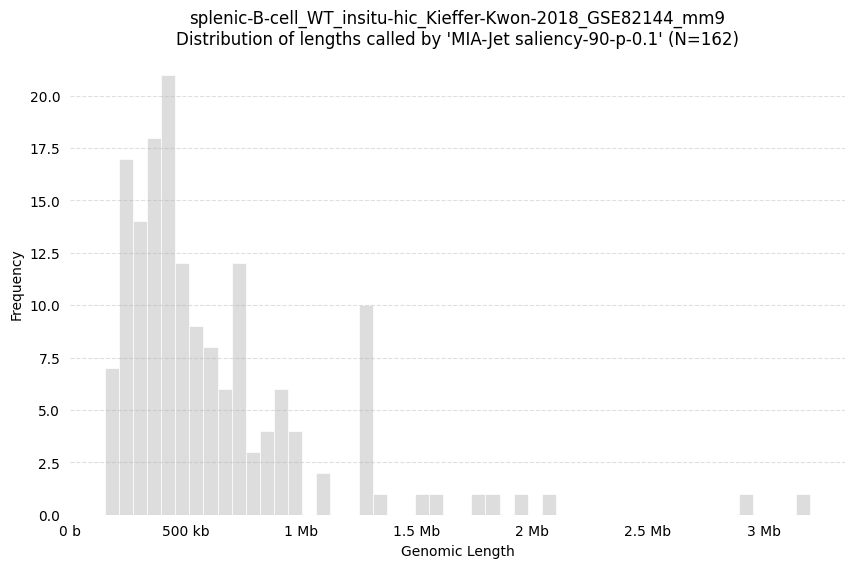

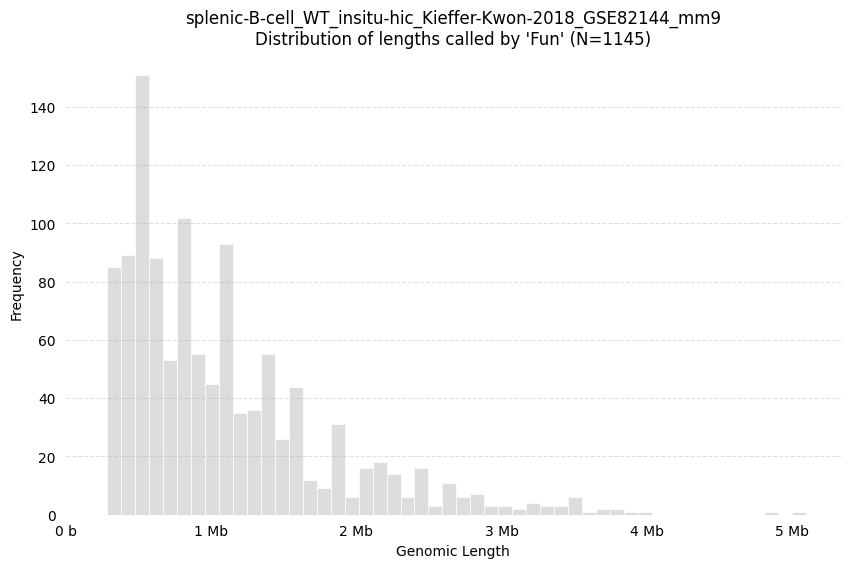

Lengths for Fontanka are not available, skipping length histogram.


In [117]:
# PLOT LENGTH DISTRIBUTION OF ALL CALLED
for i, s in enumerate(tables):

    lengths = s["length"].values

    if lengths[0] == -1:
        print(f"Lengths for {names[i]} are not available, skipping length histogram.")
        continue

    plot_length_histogram(lengths, 
                          title=f"{data_name}\nDistribution of lengths called by '{names[i]}' (N={len(lengths)})",
                          bins=50,
                          show=True, 
                          save_name=f"{save_path}/{data_name}_length_distribution_{names[i]}.png")

Retrieving pileups: 100%|██████████| 162/162 [00:04<00:00, 33.57it/s]


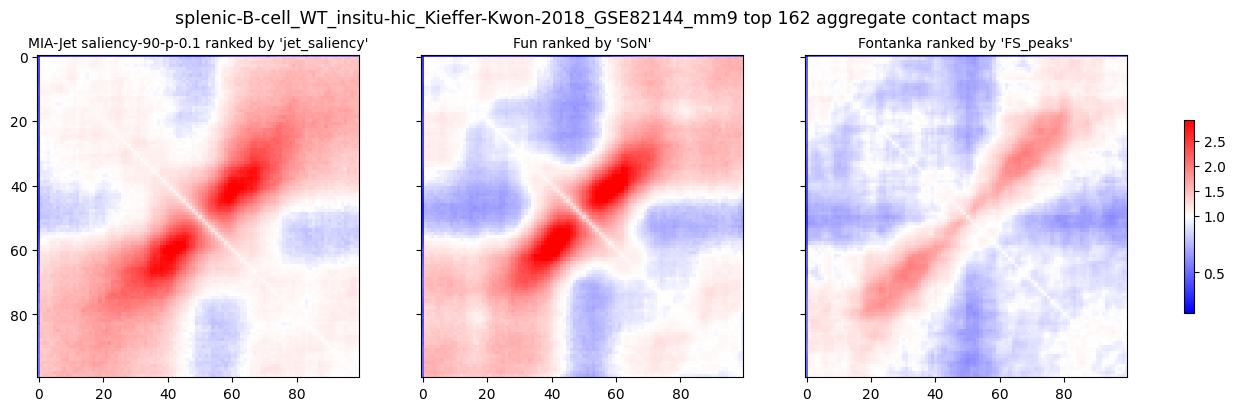

In [6]:
# PLOT TOP N
agg_map = []
vmaxes = []
stacks = []
df_stack = []
resolutions = []
chipseq_stacks = []
for bed_df in top_bed_tables:
    # Get pileups for each bed_df
    s, d, r = get_pileups_dynamic_resolution(
        hic_file=hic_file,
        bed_df_in=bed_df,
        expected_stack_size=expected_stack_size,
        chrom_sizes=chrom_sizes,
        chromosomes='all',
        window_range=(None, None),
        data_type=data_type,
        normalization=normalization,
        sort=True,
        verbose=True
    )

    # Remove centromeres and resize square stacks
    s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

    if data_type == "observed":
        s = np.log10(s + 1) # log transform for visualization

    a = np.mean(s, axis=0)
    vmaxes.append(np.percentile(a, 99))  # store the 99th percentile for color scaling
    agg_map.append(a)  # average over all stacks
    stacks.append(s)  # store the stacks for later use
    df_stack.append(d)  # store the DataFrame for later use
    resolutions.append(r)  # store the resolution for later use

titles = [f"{names[i]} ranked by '{ranking_col[i]}'" for i in range(len(names))]

if data_type == "observed":
    cmap = "Reds"
    vcenter = None
else:
    cmap = "bwr"
    vcenter = 1

plot_n_hic(
    agg_map,
    suptitle=f"{data_name} top {N} aggregate contact maps",
    resolution=None,
    cmap_label=None,
    titles=titles,
    cmap=cmap,
    vcenter=vcenter,
    show=True, 
    vmax=vmaxes,
    ppr=4, 
    standardize_cbar=True,
    # savepath=f"{save_path}/{data_name}_topN_agg_map-{data_type}.png"
)

In [10]:
problematic_indices = []
for i in range(len(stacks[0])):
    if np.allclose(stacks[0][i], 0):
        print(i)
        problematic_indices.append(i)

df_stack[0].iloc[problematic_indices]

Empty DataFrame
Columns: [unique_id, chrom, length, input_mean, angle_mean, width_mean, jet_saliency, ks, p-val_raw, p-val_corr, stripiness, start, end]
Index: []

In [ ]:
# PLOT DIAGNOSTIC OF TOP N
method_names = [f"{names[i]} ranked by '{ranking_col[i]}'" for i in range(len(names))]

for idx in range(len(names)):
    
    suptitle = method_names[idx]

    # Select top jets according to "jet_saliency" column
    top_n = 42  
    # 1) get the original row‐indices of the top N
    top_idx = df_stack[idx].nlargest(top_n, ranking_col[idx]).index

    # 2) subset the DataFrame (and only then reset if you like)
    sampled_df_stack = df_stack[idx].loc[top_idx].reset_index(drop=True)

    # 3) subset the array with those SAME indices
    sampled_stack = stacks[idx][top_idx]

    titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
    titles += f" ({ranking_col[idx]}: " + sampled_df_stack[ranking_col[idx]].map(lambda x : f"{x:.3g}") + ")"
    titles += f"\nResolution: " + pd.Series([genomic_labels(r, N=1) for r in resolutions[idx]]).astype(str) 
    titles = titles.tolist()

    genomic_shift = sampled_df_stack["start"].to_numpy()

    vmaxes = [np.percentile(s, 99) for s in sampled_stack]

    plot_n_hic(sampled_stack, 
            titles=titles, 
            resolution=resolutions[idx],
            suptitle=f"{suptitle} N={top_n}\n{data_type} {normalization}", 
            show=False, 
            genomic_shift=genomic_shift, 
            cmap_label=None, 
            vmax=vmaxes,
            ppr=6,
            savepath=f"{save_path}/{data_name}_individual-topN_{data_type}_{names[idx]}_{ranking_col[idx]}.png",
            cmap="Reds")

In [ ]:


# # PLOT ALL CALLED
# agg_map = []
# vmaxes = []
# stacks = []
# df_stack = []
# resolutions = []
# chipseq_stacks = []
# # for each 

# # resolutions = []
# for bed_df in bed_tables:
#     # Get pileups for each bed_df
#     s, d, r = get_pileups_dynamic_resolution(
#         hic_file=hic_file,
#         bed_df_in=bed_df,
#         expected_stack_size=expected_stack_size,
#         chrom_sizes=chrom_sizes,
#         chromosomes='all',
#         window_range=(None, None),
#         data_type=data_type,
#         normalization=normalization,
#         sort=True,
#         verbose=True
#     )

#     # Remove centromeres and resize square stacks
#     s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

#     if data_type == "observed":
#         s = np.log10(s + 1) # log transform for visualization

#     a = np.mean(s, axis=0)
#     vmaxes.append(np.percentile(a, 99))  # store the 99th percentile for color scaling
#     agg_map.append(a)  # average over all stacks
#     stacks.append(s)  # store the stacks for later use
#     df_stack.append(d)  # store the DataFrame for later use
#     resolutions.append(r)  # store the resolution for later use

# titles = [f"{names[i]} (N={len(df_stack[i])})" for i in range(len(names))]

# plot_n_hic(
#     agg_map,
#     suptitle=f"{data_name} All Called aggregate contact maps",
#     resolution=None,
#     cmap_label=None,
#     titles=titles,
#     cmap='Reds',
#     show=False, 
#     vmax=vmaxes,
#     ppr=4,
#     savepath=f"{save_path}/{data_name}_all_agg_map-{data_type}.png"
# )


# # COMPUTE OVERLAPS
# results = pd.DataFrame(index=names, columns=names, dtype=int).fillna(0)
# unique_identifiers = []
# name_pairs = []
# # fill main diagonal with the total number of jets from each method
# for n in names:
#     results.loc[n, n] = len(table_dict[n])

# for n1, n2 in itertools.combinations(names, 2):

#     print("-" * 20)
#     print(f"Comparing {n1} and {n2}...")

#     genome_wide_overlap = 0
#     identifiers = []

#     for chrom in common_chroms:
#         # IOU method is per-chromosome so filter each table by chromosome
#         t1 = position_dict[n1].loc[position_dict[n1]["chrom"] == chrom]
#         t2 = position_dict[n2].loc[position_dict[n2]["chrom"] == chrom]

#         # Summary tables to get the number of jets called by each method
#         s1 = table_dict[n1].loc[table_dict[n1]["chrom"] == chrom]
#         s2 = table_dict[n2].loc[table_dict[n2]["chrom"] == chrom]

#         # Compute the pairs of jets in each direction
#         pairs12 = match_by_iou(t1, t2, buffer_radius, iou_threshold)
#         pairs21 = match_by_iou(t2, t1, buffer_radius, iou_threshold)

#         # Construct graph and find unique pairs
#         pairs = unique_pairs(pairs12, pairs21, method="optimal")

#         # print(f"* {chrom}: {len(pairs)} pairs between {n1} ({len(s1)}) and {n2} ({len(s2)})")

#         genome_wide_overlap += len(pairs)
#         identifiers += pairs # extend the list

#     # Update reuslts table
#     results.loc[n1, n2] = genome_wide_overlap
#     results.loc[n2, n1] = genome_wide_overlap  # symmetric

#     unique_identifiers.append(identifiers)
#     name_pairs.append((n1, n2))
    
# print("Genome-wide overlaps:")
# print(results)


# # COLLECT AGG DATA / PLOT DIAGNOSTIC OVERLAPS
# agg_map_pairs = [] # aggregate contact map data
# jet_strength_pairs = [] # jet strength correlation data
# for (n1, n2), pairs in zip(name_pairs, unique_identifiers):
#     safe_convert = np.vectorize(safe_int)
#     df_intersections = []

#     if len(pairs) == 0:
#         uid1 = np.array([])  
#         uid2 = np.array([])  
#     else:
#         uid1 = np.array(pairs)[:, 0]  # unique identifiers from n1
#         uid2 = np.array(pairs)[:, 1]  # unique identifiers from n2

#         uid1 = safe_convert(uid1)
#         uid2 = safe_convert(uid2)

#     df1 = pd.DataFrame({"unique_id" : uid1,})
#     df2 = pd.DataFrame({"unique_id" : uid2,})
#     # Use n1
#     A_name = n1
#     B_name = n2
#     # Summary dataframe
#     df_A = table_dict[n1]
#     df_B = table_dict[n2]
#     # These will be used to merge to extract the relevant positions
#     df_id = df1
#     df_id_alt = df2
#     # Expanded dataframe 
#     df_pos_A = position_dict[n1].copy()
#     df_pos_B = position_dict[n2].copy()

#     # These are the "main" summary dataframes
#     # That should be sufficien to plot the aggregate contact maps and boxplots
#     df_intersection = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
#     df_diff_A = df_A[~df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
#     df_diff_B = df_B[~df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

#     # Assertions to ensure that the intersection and difference cover the whole table
#     assert len(df_intersection) + len(df_diff_A) == len(df_A), "The intersection and difference should cover the whole table"
#     assert len(df_intersection) + len(df_diff_B) == len(df_B), "The intersection and difference should cover the whole table"

#     # CORRELATION 
#     # Lets get the jet strength correlation between different jet callers, which is only possible for the intersection
#     # Since these are the jets that are called by both methods, enabling correlation plots
#     df_intersection_A = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
#     df_intersection_B = df_B[df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

#     A_idx = names.index(n1)
#     B_idx = names.index(n2)
#     # Construct dictionaries for jet strengths
#     strength_A = df_A.set_index("unique_id")[ranking_col[A_idx]].to_dict()
#     strength_B = df_B.set_index("unique_id")[ranking_col[B_idx]].to_dict()

#     # extract in the same order
#     js_A = [strength_A.get(u, np.nan) for u in uid1]
#     js_B = [strength_B.get(u, np.nan) for u in uid2]

#     jet_strength_pairs.append(np.array([js_A, js_B]))

#     # AGGREGATE CONTACT MAPS
#     # Lets get the positions, which is better to plot the individual Hi-C diagnostic plots
#     # These diagnostic plots are meant to confirm that the overlapping parameters are good
#     df_pos_intersection = df_pos_A[df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
#     df_pos_diff_A = df_pos_A[~df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
#     df_pos_diff_B = df_pos_B[~df_pos_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

#     plot_overlap_diagnostic(
#         hic_file=hic_file,
#         plot_chrom=common_chroms[0],  
#         resolution=resolution,
#         data_type="observed",
#         normalization="VC_SQRT",
#         A_name=A_name,
#         B_name=B_name,
#         df_pos_A=df_pos_A,
#         df_pos_B=df_pos_B,
#         df_pos_intersection=df_pos_intersection,
#         df_pos_diff_A=df_pos_diff_A,
#         df_pos_diff_B=df_pos_diff_B,
#         save_path=save_path,
#         data_name=data_name
#     )

#     # Make bed files to get stacks
#     bed_intersection = generate_bed_2(df_intersection, df_pos_intersection, eps=500e3, fraction=1.5)
#     bed_diff_A = generate_bed_2(df_diff_A, df_pos_diff_A, eps=500e3, fraction=1.5)
#     bed_diff_B = generate_bed_2(df_diff_B, df_pos_diff_B, eps=500e3, fraction=1.5)

#     chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

#     bed_frames = [bed_diff_A, bed_intersection, bed_diff_B]
#     bed_names = [f"{A_name} only", f"{A_name} & {B_name}", f"{B_name} only"]

#     agg_map = []
#     # resolutions = []
#     for bed_df, name in zip(bed_frames, bed_names):
#         # Get pileups for each bed_df
#         s, d, r = get_pileups_dynamic_resolution(
#             hic_file=hic_file,
#             bed_df_in=bed_df,
#             expected_stack_size=expected_stack_size,
#             chrom_sizes=chrom_sizes,
#             chromosomes='all',
#             window_range=(None, None),
#             data_type=data_type,
#             normalization=normalization,
#             sort=True,
#             verbose=True
#         )

#         # Remove centromeres and resize square stacks
#         s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

#         if data_type == "observed":
#             s = np.log10(s + 1) # log transform for visualization

#         agg_map.append(np.mean(s, axis=0))  # average over all stacks
#         # resolutions.append(r)

#     agg_map_pairs.append(agg_map)

# agg_map_pairs = np.array(agg_map_pairs)

# # PLOT VENN DIAGRAM
# pairs = list(itertools.combinations(names, 2))
# num_pairs = len(pairs)

# fig, axes = plt.subplots(num_pairs, 4, figsize=(5*4, 5*num_pairs), layout='constrained', width_ratios=[2, 1, 1, 1])

# for row, (A, B) in enumerate(pairs):
#     # compute overlaps as before
#     total_A = results.loc[A, A]
#     total_B = results.loc[B, B]
#     inter   = results.loc[A, B]
#     only_A  = total_A - inter
#     only_B  = total_B - inter

#     # column 0: the Venn
#     ax = axes[row, 0]
#     venn2(subsets=(int(only_A), int(only_B), int(inter)),
#         set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
#         ax=ax)
#     ax.set_title(f"{A} vs {B}")

#     # columns 1–3: the three imshows
#     # agg_map_pairs.shape == (n_pairs, 3, H, W)
#     titles = [f"{A} only", f"{A} & {B}", f"{B} only"]
#     counts = [int(only_A), int(inter), int(only_B)]
#     row_imgs = agg_map_pairs[row]
#     row_vmax = max(np.percentile(img, 99) for img in row_imgs)
#     for col_idx in range(3):
#         ax = axes[row, col_idx+1]
#         img = agg_map_pairs[row, col_idx]
#         im = ax.imshow(img, cmap="Reds", interpolation="none", vmax=np.percentile(img, 99))
#         ax.set_title(f"{titles[col_idx]} (N={counts[col_idx]})")
#         ax.axis('off')
#     fig.colorbar(im, ax=axes[row, 1:], fraction=0.02, pad=0.04, label=f"Mean of '{data_type}'")


# fig.suptitle(f"Jet Caller Comparison for {data_name}\nOverlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution}bp", fontsize=16)

# plt.savefig(f"{save_path}/{data_name}_venn_diagram-agg.png", dpi=300)

# plt.close()



# # PLOT VENN DIAGRAM + CORRELATION
# from scipy.stats import linregress

# pairs = list(itertools.combinations(names, 2))
# num_pairs = len(pairs)

# fig, axes = plt.subplots(num_pairs, 2, figsize=(14, 5 * num_pairs), constrained_layout=True, width_ratios=[2, 1])

# for row, (A, B) in enumerate(pairs):
#     # compute overlap counts
#     total_A = results.loc[A, A]
#     total_B = results.loc[B, B]
#     inter = results.loc[A, B]
#     only_A = total_A - inter
#     only_B = total_B - inter

#     # Venn Diagram
#     ax0 = axes[row, 0] if num_pairs > 1 else axes[0]
#     venn2(subsets=(int(only_A), int(only_B), int(inter)),
#             set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"), ax=ax0)
#     ax0.set_title(f"{A} vs {B}")

#     # Correlation plots
#     ax1 = axes[row, 1] if num_pairs > 1 else axes[1]

#     if inter == 0:
#         # Delete the axis 
#         ax1.axis('off')
#     else:
#         js = jet_strength_pairs[row] # shape (2, N)
#         x  = np.array(js[0], dtype=float) # A strengths
#         y  = np.array(js[1], dtype=float) # B strengths

#         # fit line and compute R2
#         result = linregress(x, y)
#         y_fit = result.intercept + result.slope * x
#         r2 = result.rvalue ** 2

#         # plot
#         ax1.scatter(x, y, alpha=1, s=10)
#         ax1.plot(x, y_fit, color='k', linewidth=2, )
#         ax1.set_box_aspect(1)
#         ax1.set_xlabel(f"{A} jet strength")
#         ax1.set_ylabel(f"{B} jet strength")
#         ax1.set_title(f"R2 = {r2:.3f}")

# # overall title
# fig.suptitle(f"Jet Strength Correlation for {data_name}\n" 
#             f"Overlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution} bp", 
#             fontsize=16)

# plt.savefig(f"{save_path}/{data_name}_venn_diagram-line.png", dpi=300)


# plt.close()


Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
Current N is too large for some jet callers.
Adjusting N from 100 to 394


Retrieving pileups: 100%|██████████| 394/394 [00:04<00:00, 81.27it/s]


# DP thymocytes (Guo et al. 2022)

The reason why we separate DP thymocyte and other cell lines is because 
1. Guo et al. has manual annotations which we consider as another "jet caller" 
2. DP thymocytes has ChIP-seq tracks which we wish to plot also

In [3]:
hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/GSE199059_CD69negDPWTR1R2R3R4_merged.hic"
data_name = "GSE199059_CD69negDPWTR1R2R3R4_merged-stripiness-1-p-enrich-0.3"

# FUN
f_pred_fun_bedpe = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_GSE199059_CD69negDPWTR1R2R3R4_merged_mm9/FUN-pred_50000_1.3.bedpe"
f_pred_fun_tab = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_GSE199059_CD69negDPWTR1R2R3R4_merged_mm9/FUN-pred_50000_1.3.tab"

# FONTANKA
f_pred_fontanka = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_GSE199059_CD69negDPWTR1R2R3R4_merged.50000.predicted.fountains.thresholded.tsv"

# MIA-JET
result_type = "saliency-90-p-0.1" # MIA-Jet
# result_type = "p-0.1"  # MIA-Jet
# f_pred_miajet_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined_50Kb/GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined_{result_type}_50Kb_summary_table.csv"
# f_pred_miajet_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined_50Kb/GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined_{result_type}_50Kb_expanded_table.csv"
f_pred_miajet_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/GSE199059_CD69negDPWTR1R2R3R4_merged-stripiness-1-p-enrich-0.3_chr_combined_50Kb/GSE199059_CD69negDPWTR1R2R3R4_merged-stripiness-1-p-enrich-0.3_chr_combined_{result_type}_50Kb_summary_table.csv"
f_pred_miajet_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/GSE199059_CD69negDPWTR1R2R3R4_merged-stripiness-1-p-enrich-0.3_chr_combined_50Kb/GSE199059_CD69negDPWTR1R2R3R4_merged-stripiness-1-p-enrich-0.3_chr_combined_{result_type}_50Kb_expanded_table.csv"

# HAND-PICKED (Guo et al. 2022 DP thymocytes ONLY)
f_guo37 = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/GUO-37_mm9.tsv"

# AUXILIAR DATA (ChIP-seq)
chip_files = [
    "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph",
    # "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R2_chipseq_Guo-2022_GSM5963433_mm9.bedGraph",
    "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph",
    # "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R2_chipseq_Guo-2022_GSM5963435_mm9.bedGraph",
    "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph",
    # "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R2_chipseq_Guo-2022_GSM5963437_mm9.bedGraph",
    "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph",
    # "/nfs/turbo/umms-minjilab/processing/results/SRR931713/dp_thymocytes_NIPBL_SRR931713_miseq.q30.nr.sorted.bedgraph",
    "/nfs/turbo/umms-minjilab/processing/results/SRR931714/dp_thymocytes_NIPBL_SRR931714_miseq.q30.nr.sorted.bedgraph",
]

chip_names = [
    "ChIP-seq input control GSM5963432 (R1)",
    # "ChIP-seq input control GSM5963433 (R2)",
    "ChIP-seq H3K27ac GSM5963434 (R1)",
    # "ChIP-seq H3K27ac GSM5963435 (R2)",
    "ChIP-seq RAD21 GSM5963436 (R1)",
    # "ChIP-seq RAD21 GSM5963437 (R2)",
    "ChIP-seq CTCF GSM5963438",
    # "ChIP-seq NIPBL SRR931713 (R1)",
    "ChIP-seq NIPBL SRR931714 (R2)",
]

chip_names_abrev = ["Input", "H3K27ac", "RAD21", "CTCF", "NIPBL"]

genome = "mm9"
f_chrom_sizes = "/nfs/turbo/umms-minjilab/processing/genomes/mm9/mm9.chrom.sizes"

# Common parameters
save_path = "/nfs/turbo/umms-minjilab/sionkim/miajet_analysis"

# Should be the resolution of the miajet program
# This should be standardized across all methods
# This parameter is used to define the sampling frequency of the jet lines 
resolution = 50000 # 50Kb resolution

# Pileup parameters
expected_stack_size = 100
data_type = "oe"
normalization = "KR"

In [ ]:
guo37_table = pd.read_csv(f_guo37, sep="\t")

In [5]:
# For the other jet callers, we just copy the code from ##Other cell lines

# Load it in
fun_bedpe = pd.read_csv(f_pred_fun_bedpe, sep="\t")
fun_table = pd.read_csv(f_pred_fun_tab, sep="\t")

fontanka_table = pd.read_csv(f_pred_fontanka, sep="\t", index_col=0)
fontanka_table.dropna(inplace=True, how="any")
fontanka_table.reset_index(inplace=True, drop=True)

miajet_positions = pd.read_csv(f_pred_miajet_expanded, comment="#")
miajet_table = pd.read_csv(f_pred_miajet_summary, comment="#")

# Common chromosome determination
# Lets not include Guo et al. because they didn't find any in chrX
# For a fair comparison of overlaps, we will only consider the common chromosomes

chromsizes = bf.fetch_chromsizes(db=genome, as_bed=True)
common_chroms = chromsizes["chrom"].tolist()
# common_chroms = set(fun_table["chrom"].unique()) & set(fontanka_table["chrom"].unique()) & set(miajet_table["chrom"].unique()) 
# common_chroms = list(common_chroms)

miajet_table = miajet_table[miajet_table["chrom"].isin(common_chroms)]
fun_table = fun_table[fun_table["chrom"].isin(common_chroms)]
fontanka_table = fontanka_table[fontanka_table["chrom"].isin(common_chroms)]

print(f"Common chromosomes: {common_chroms}")

Common chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM']


## Preprocessing

In [6]:
# Flip because we wish to minimize these quantities
# miajet_table["rmse"] *= -1
# miajet_table["entropy"] *= -1

# miajet_table["stripiness"] *= -1
miajet_table

unique_id  chrom         start           end   length  input_mean  \
0    chr2_7701_0   chr2  7.905646e+07  7.951752e+07   650000       0.242   
1    chr2_131_10   chr2  1.155614e+08  1.161160e+08  1150000       0.165   
2      chr2_94_6   chr2  1.662365e+08  1.663939e+08   300000       0.230   
3      chr2_3_11   chr2  9.517042e+06  1.020590e+07  1150000       0.254   
4    chr2_751_17   chr2  1.138397e+07  1.218821e+07  1250000       0.192   
5   chr2_1254_12   chr2  4.481502e+07  4.533418e+07   800000       0.245   
6      chr3_7_14   chr3  3.790186e+07  3.868163e+07  1100000       0.298   
7     chr3_10_14   chr3  5.661763e+06  6.623542e+06  1500000       0.275   
8   chr5_1005_13   chr5  5.852715e+07  5.966653e+07  1600000       0.032   
9     chr5_109_0   chr5  1.502087e+08  1.503996e+08   600000       0.057   
10     chr6_8_17   chr6  4.142258e+07  4.238987e+07  1200000       0.303   
11   chr8_899_10   chr8  1.091697e+07  1.117977e+07   600000       0.226   
12      chr8_2_8   chr8  1.292890e+08  1.296196e+08   600000       0.236   
13     chr9_5_18   chr9  2.135628e+07  2.210133e+07  1050000       0.228   
14   chr11_13_18  chr11  1.029478e+07  1.069511e+07   700000       0.257   
15  chr11_3117_3  chr11  7.939654e+06  8.245290e+06   550000       0.194   
16  chr11_959_11  chr11  2.639995e+07  2.685635e+07  1300000       0.227   
17    chr13_10_9  chr13  1.150474e+08  1.156693e+08   850000       0.153   
18  chr13_1912_5  chr13  4.213537e+07  4.235103e+07   350000       0.143   
19    chr13_3_19  chr13  5.700444e+06  6.166176e+06   750000       0.123   
20  chr14_132_14  chr14  6.556132e+07  6.635156e+07  1600000       0.030   
21    chr14_2_13  chr14  5.462724e+07  5.563741e+07  2200000       0.063   
22    chr14_18_8  chr14  1.135893e+07  1.218250e+07  1750000       0.060   
23  chr16_1190_6  chr16  2.482800e+07  2.533563e+07   750000       0.193   
24  chr16_2139_3  chr16  9.336072e+07  9.372900e+07   550000       0.193   
25   chr18_79_15  chr18  2.111156e+07  2.195724e+07  1250000       0.139   
26    chrX_326_8   chrX  4.953856e+07  5.005800e+07   800000       0.021   
27     chrX_69_8   chrX  1.393380e+08  1.398318e+08   750000       0.027   

    angle_mean  width_mean  jet_saliency     ks  p-val_raw  p-val_corr  \
0       67.506       2.507         0.078  0.692      0.001       0.007   
1      113.008       4.801         0.099  0.478      0.005       0.017   
2       89.441       4.017         0.075  1.000      0.001       0.005   
3       99.127       7.354         0.072  0.826      0.000       0.000   
4       84.599       9.265         0.110  0.600      0.000       0.001   
5       92.369       6.748         0.298  0.938      0.000       0.000   
6       66.409       7.112         0.138  0.500      0.004       0.024   
7       93.320       7.417         0.516  0.933      0.000       0.000   
8       88.456       8.985         0.042  0.594      0.000       0.000   
9      112.699       3.522         0.014  0.917      0.000       0.000   
10      77.938      10.157         0.142  0.542      0.001       0.007   
11     105.687       3.798         0.075  0.833      0.000       0.002   
12      94.752       3.792         0.225  0.833      0.000       0.002   
13      84.182      13.437         0.175  0.476      0.008       0.044   
14      96.015      10.064         0.146  1.000      0.000       0.000   
15      96.497       4.296         0.119  0.636      0.010       0.040   
16     111.246       6.163         0.115  0.654      0.000       0.000   
17      72.740       4.424         0.035  0.941      0.000       0.000   
18      88.182       3.680         0.056  0.714      0.027       0.081   
19      97.647      12.077         0.051  0.733      0.000       0.001   
20     102.928      10.340         0.017  0.688      0.000       0.000   
21     104.123       8.005         0.053  0.636      0.000       0.000   
22     103.630       6.528         0.061  0.514      0.000       0.001   
23      86.050       6.121

In [7]:
# midpoint
fun_bedpe["extrusion_x"] = (fun_bedpe["y1"] + fun_bedpe["y2"]) / 2
fun_bedpe["extrusion_y"] = (fun_bedpe["x1"] + fun_bedpe["x2"]) / 2

# guarantees that the extrusion point is in the upper diagonal
# doesn't matter except for convention but should be standardized for all points
assert np.all(fun_bedpe["extrusion_x"] >= fun_bedpe["extrusion_y"])

# the main table hosts the "start" and "end" positions, which is the main diagonal start and end
# to get a single point for the jet, we can use the midpoint of the start and end positions
fun_table["root"] = (fun_table["start"] + fun_table["end"]) / 2
# Note that "root" position should technically be "root_x" and "root_y" but since 
# this is a point on the main diagonal, they are the same and we can just use one value

# Lets add a unique identifier now
fun_table["unique_id"] = fun_table.index

# Lets combine them
fun_minimal = fun_bedpe.copy()

fun_minimal["root"] = fun_table["root"]

# Lets add a unique identifier now
fun_minimal["unique_id"] = fun_minimal.index
fun_minimal["chrom"] = fun_table["chrom"]

fun_minimal = fun_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

fun_positions = generate_positions(fun_minimal, resolution)
fun_positions["unique_id"] = fun_positions["unique_id"].astype(int)

fun_positions

unique_id chrom        x (bp)        y (bp)
0              0  chr1  1.423500e+08  1.416500e+08
1              0  chr1  1.423083e+08  1.416861e+08
2              0  chr1  1.422667e+08  1.417222e+08
3              0  chr1  1.422250e+08  1.417583e+08
4              0  chr1  1.421833e+08  1.417944e+08
...          ...   ...           ...           ...
23489       1094  chrX  6.892763e+07  6.863289e+07
23490       1094  chrX  6.888947e+07  6.866842e+07
23491       1094  chrX  6.885132e+07  6.870395e+07
23492       1094  chrX  6.881316e+07  6.873947e+07
23493       1094  chrX  6.877500e+07  6.877500e+07

[23494 rows x 4 columns]

In [8]:
fontanka_table = fontanka_table.reset_index(drop=True)
fontanka_table["root"] = (fontanka_table["end"] + fontanka_table["start"]) / 2
fontanka_table["unique_id"] = fontanka_table.index
fontanka_table["extrusion_x"] = fontanka_table["window_end"]
fontanka_table["extrusion_y"] = fontanka_table["window_start"]

# guarantees that the extrusion point is in the upper diagonal
# doesn't matter except for convention but should be standardized for all points
assert np.all(fontanka_table["extrusion_x"] >= fontanka_table["extrusion_y"])

fontanka_minimal = fontanka_table.copy()

fontanka_minimal = fontanka_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

fontanka_positions = generate_positions(fontanka_minimal, resolution)
fontanka_positions["unique_id"] = fontanka_positions["unique_id"].astype(int)

fontanka_positions

unique_id chrom        x (bp)        y (bp)
0              0  chr1  1.365000e+07  1.600000e+06
1              0  chr1  1.361456e+07  1.635441e+06
2              0  chr1  1.357912e+07  1.670882e+06
3              0  chr1  1.354368e+07  1.706324e+06
4              0  chr1  1.350824e+07  1.741765e+06
...          ...   ...           ...           ...
54715        319  chrX  1.526168e+08  1.523332e+08
54716        319  chrX  1.525813e+08  1.523687e+08
54717        319  chrX  1.525459e+08  1.524041e+08
54718        319  chrX  1.525104e+08  1.524396e+08
54719        319  chrX  1.524750e+08  1.524750e+08

[54720 rows x 4 columns]

In [9]:
guo37_table = guo37_table.reset_index(drop=True)

guo37_table["extrusion_x"] = (guo37_table["Pos_kb"] + guo37_table["WT_d2_kb"]) * 1000
guo37_table["extrusion_y"] = (guo37_table["Pos_kb"] - guo37_table["WT_d1_kb"]) * 1000

assert np.all(guo37_table["extrusion_x"] >= guo37_table["extrusion_y"])

guo37_table["root"] = guo37_table["Pos_kb"] * 1000

guo37_table["chrom"] = "chr" + guo37_table["Chr"].astype(str)

guo37_table["unique_id"] = guo37_table.index

guo37_table["start"] = (guo37_table["Pos_kb"] - 1) * 1000
guo37_table["end"] = (guo37_table["Pos_kb"] + 1) * 1000

guo37_minimal = guo37_table.copy()
guo37_minimal = guo37_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]
guo37_positions = generate_positions(guo37_minimal, resolution)


guo37_positions

unique_id  chrom        x (bp)        y (bp)
0            0   chr1  1.905910e+08  1.887005e+08
1            0   chr1  1.905422e+08  1.887148e+08
2            0   chr1  1.904935e+08  1.887290e+08
3            0   chr1  1.904447e+08  1.887432e+08
4            0   chr1  1.903959e+08  1.887575e+08
..         ...    ...           ...           ...
772         35  chr19  1.469600e+07  1.462191e+07
773         35  chr19  1.466300e+07  1.466300e+07
774         36  chr19  1.882000e+07  1.862000e+07
775         36  chr19  1.877000e+07  1.867000e+07
776         36  chr19  1.872000e+07  1.872000e+07

[777 rows x 4 columns]

In [10]:
# Expanded
positions = [
    miajet_positions,
    fun_positions,
    fontanka_positions, 
    guo37_positions
]

# Summary
tables = [
    miajet_table,
    fun_table,
    fontanka_table,
    guo37_table
]

names = [
    f"MIA-Jet {result_type}",
    "Fun",
    "Fontanka",
    "Guo et al. 2022"
]

ranking_col = [
    "stripiness", # changed! 
    "SoN", 
    "FS_peaks", 
    "Strength_au_WT"
]

position_dict = dict(zip(names, positions))
table_dict = dict(zip(names, tables))

In [11]:
bed_tables = []
for i, (s, e) in enumerate(zip(tables, positions)):
    # bed_tables.append(generate_bed_df(s, e, eps=500e3, fraction=0.5))
    bed_tables.append(generate_bed_2(s, e, eps=500e3, fraction=1.5))

chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

In [12]:
bed_tables[0]

unique_id  chrom   length  input_mean  angle_mean  width_mean  \
0    chr2_7701_0   chr2   650000       0.242      67.506       2.507   
1    chr2_131_10   chr2  1150000       0.165     113.008       4.801   
2      chr2_94_6   chr2   300000       0.230      89.441       4.017   
3      chr2_3_11   chr2  1150000       0.254      99.127       7.354   
4    chr2_751_17   chr2  1250000       0.192      84.599       9.265   
5   chr2_1254_12   chr2   800000       0.245      92.369       6.748   
6      chr3_7_14   chr3  1100000       0.298      66.409       7.112   
7     chr3_10_14   chr3  1500000       0.275      93.320       7.417   
8   chr5_1005_13   chr5  1600000       0.032      88.456       8.985   
9     chr5_109_0   chr5   600000       0.057     112.699       3.522   
10     chr6_8_17   chr6  1200000       0.303      77.938      10.157   
11   chr8_899_10   chr8   600000       0.226     105.687       3.798   
12      chr8_2_8   chr8   600000       0.236      94.752       3.792   
13     chr9_5_18   chr9  1050000       0.228      84.182      13.437   
14   chr11_13_18  chr11   700000       0.257      96.015      10.064   
15  chr11_3117_3  chr11   550000       0.194      96.497       4.296   
16  chr11_959_11  chr11  1300000       0.227     111.246       6.163   
17    chr13_10_9  chr13   850000       0.153      72.740       4.424   
18  chr13_1912_5  chr13   350000       0.143      88.182       3.680   
19    chr13_3_19  chr13   750000       0.123      97.647      12.077   
20  chr14_132_14  chr14  1600000       0.030     102.928      10.340   
21    chr14_2_13  chr14  2200000       0.063     104.123       8.005   
22    chr14_18_8  chr14  1750000       0.060     103.630       6.528   
23  chr16_1190_6  chr16   750000       0.193      86.050       6.121   
24  chr16_2139_3  chr16   550000       0.193      78.277       4.779   
25   chr18_79_15  chr18  1250000       0.139      89.399       9.009   
26    chrX_326_8   chrX   800000       0.021      91.648       5.398   
27     chrX_69_8   chrX   750000       0.027      92.405       5.605   

    jet_saliency     ks  p-val_raw  p-val_corr  stripiness         start  \
0          0.078  0.692      0.001       0.007       0.025  7.762444e+07   
1          0.099  0.478      0.005       0.017       0.013  1.137434e+08   
2          0.075  1.000      0.001       0.005       0.027  1.652109e+08   
3          0.072  0.826      0.000       0.000       0.070  7.747071e+06   
4          0.110  0.600      0.000       0.001       0.026  9.575955e+06   
5          0.298  0.938      0.000       0.000       0.073  4.342072e+07   
6          0.138  0.500      0.004       0.024       0.084  3.589611e+07   
7          0.516  0.933      0.000       0.000       0.057  3.251938e+06   
8          0.042  0.594      0.000       0.000       0.001  5.593744e+07   
9          0.014  0.917      0.000       0.000       0.002  1.486342e+08   
10         0.142  0.542      0.001       0.007       0.099  3.936732e+07   
11         0.075  0.833      0.000       0.002       0.037  9.613485e+06   
12         0.225  0.833      0.000       0.002       0.074  1.279841e+08   
13         0.175  0.476      0.008       0.044       0.067  1.956634e+07   
14         0.146  1.000      0.000       0.000       0.020  8.877657e+06   
15         0.119  0.636      0.010       0.040       0.038  6.335398e+06   
16         0.115  0.654      0.000       0.000       0.044  2.432694e+07   
17         0.035  0.941      0.000       0.000       0.020  1.135134e+08   
18         0.056  0.714      0.027       0.081       0.016  4.114078e+07   
19         0.051  0.733      0.000       0.001       0.016  4.322680e+06   
20         0.017  0.688      0.000       0.000       0.001  6.281808e+07   
21         0.053  0.636      0.000       0.000       0.004  5.149424e+07   
22         0.061  0.514      0.000       0.001       0.003  8.858985e+06   
23         0.097  0.533      0.013       0.050       0.036  2.289877e+07   
24         0.031  

## N=MIA-Jet aggregate plots

In [ ]:
N = len(bed_tables[0]) # miajet determines the number of jets to plot

In [14]:
# Now get the top N jets according to respective ranking column
top_bed_tables = []
for i, bed_df in enumerate(bed_tables):
    bed_df.sort_values(by=ranking_col[i], ascending=False, inplace=True)
    top_bed_tables.append(bed_df.head(N).reset_index(drop=True))

top_tables = []
for i, t in enumerate(tables):
    t.sort_values(by=ranking_col[i], ascending=False, inplace=True)
    top_tables.append(t.head(N).reset_index(drop=True))

In [15]:
agg_map = []
vmaxes = []
stacks = []
df_stack = []
resolutions = []
chipseq_stacks = []
# for each 

# resolutions = []
for bed_df in top_bed_tables:
    # Get pileups for each bed_df
    s, d, r = get_pileups_dynamic_resolution(
        hic_file=hic_file,
        bed_df_in=bed_df,
        expected_stack_size=expected_stack_size,
        chrom_sizes=chrom_sizes,
        chromosomes='all',
        window_range=(None, None),
        data_type=data_type,
        normalization=normalization,
        sort=True,
        verbose=True
    )

    # Remove centromeres and resize square stacks
    s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

    if data_type == "observed":
        s = np.log10(s + 1) # log transform for visualization

    a = np.mean(s, axis=0)
    vmaxes.append(np.percentile(a, 99))  # store the 99th percentile for color scaling
    agg_map.append(a)  # average over all stacks
    stacks.append(s)  # store the stacks for later use
    df_stack.append(d)  # store the DataFrame for later use
    resolutions.append(r)  # store the resolution for later use

Retrieving pileups: 100%|██████████| 28/28 [00:00<00:00, 31.15it/s]


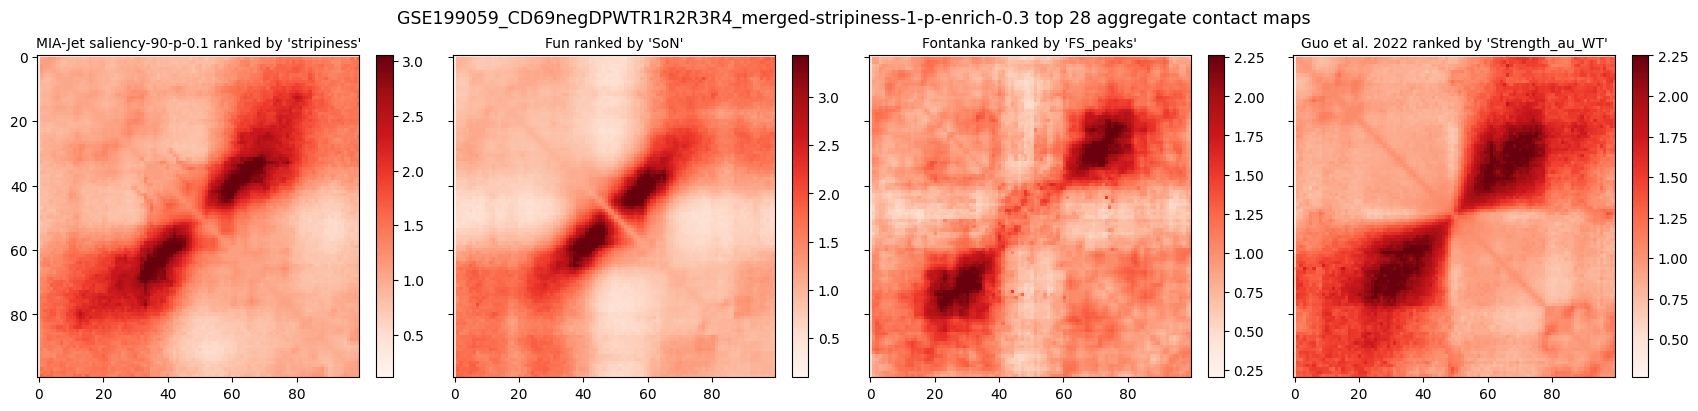

In [16]:
titles = [f"{names[i]} ranked by '{ranking_col[i]}'" for i in range(len(names))]

plot_n_hic(
    agg_map,
    suptitle=f"{data_name} top {N} aggregate contact maps",
    resolution=None,
    cmap_label=None,
    titles=titles,
    cmap='Reds',
    show=True, 
    vmax=vmaxes,
    ppr=4,
    savepath=f"{save_path}/{data_name}_{result_type}_topN-miajet_agg_map-{data_type}.png"
)

In [17]:
# Make intervals (i.e. bed tables) for ChIP-seq data extraction
stat = "max"
window_plus_minus = int(10e3) # 10 kb
chipseq_resolution = 10000 # 10kb resolution

intervals = []

for t in top_bed_tables:
    df_interval = t[["unique_id", "chrom"]].copy()
    df_interval["midpoint"] = (t["start"] + t["end"]) / 2
    df_interval["start"] = df_interval["midpoint"] - window_plus_minus
    df_interval["end"] = df_interval["midpoint"] + window_plus_minus

    intervals.append(df_interval.reset_index(drop=True))

In [18]:
chipseq_values = extract_chipseq_values(chip_files, intervals, f_chrom_sizes, common_chroms, names)

track was not included in <_io.TextIOWrapper name='/nfs/turbo/umms-minjilab/processing/genomes/mm9/mm9.chrom.sizes' mode='r' encoding='UTF-8'>


No jets called for chromosome chr1 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr4 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr7 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr10 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr12 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr15 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr17 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr19 by MIA-Jet saliency-90-p-0.1


chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo e

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chrM is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chrM by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
No jets called for chromosome chrM by Fun
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
No jets called for chromosome chrM by Fontanka
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr8 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
No jets cal

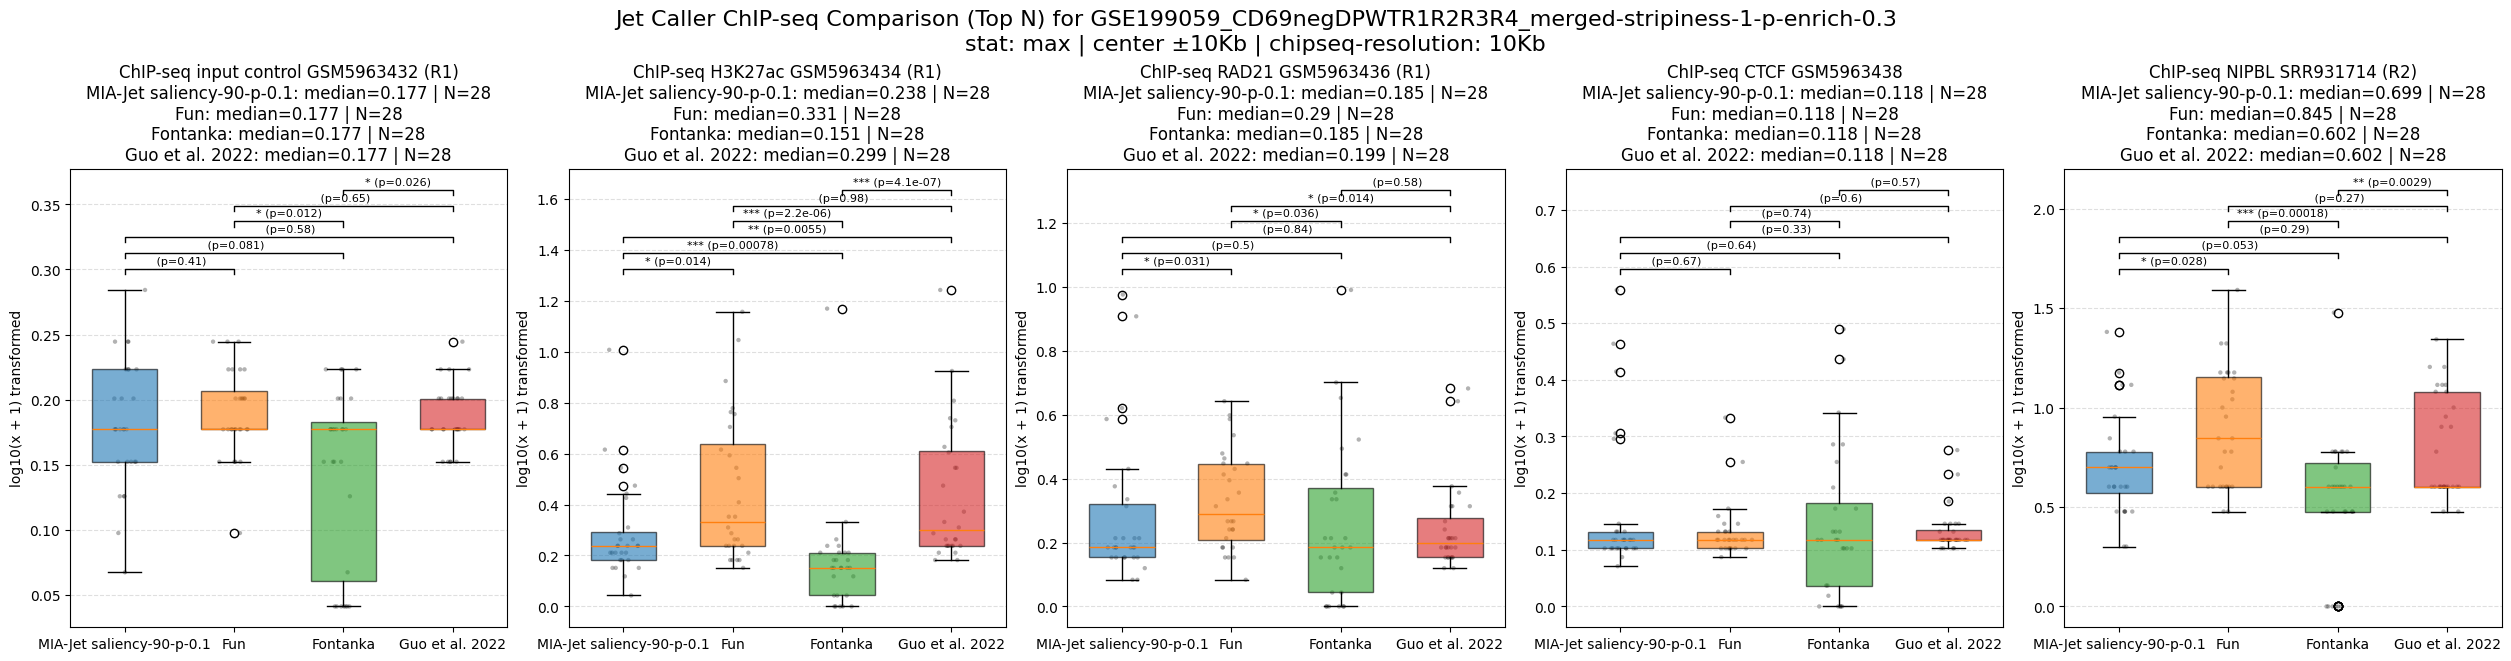

In [19]:
n_exp = len(chip_names)
n_callers = len(names)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1, n_exp, layout='constrained', figsize=(5 * len(chip_names), 6.5))

for i in range(len(chip_names)):
    chip_name = chip_names_abrev[i]

    datum = chipseq_values[i]
    boxplot_data = [list(x.values()) for x in datum]

    clean_data = [np.array(vals)[~np.isnan(vals)] for vals in boxplot_data]

    # log transform
    clean_data = [np.clip(vals, 0, None) for vals in clean_data]  # clip negative values to zero
    clean_data = [np.log10(vals + 1) for vals in clean_data]
    exp_counts = [len(vals) for vals in clean_data]
    positions = np.arange(1, n_callers + 1)

    # make boxplot titles
    title_boxstat = title_boxplot(chip_names[i], names, clean_data)

    # add pairwise significance 
    add_pairwise_sig(ax[i], positions, clean_data)

    bp = ax[i].boxplot(clean_data, patch_artist=True, positions=positions, widths=0.6)

    # color each box
    for patch, col in zip(bp['boxes'], colors[:n_callers]):
        patch.set_facecolor(col)
        patch.set_alpha(0.6)

    # jittered scatter on top
    for j, vals in enumerate(clean_data):
        y = np.array(vals)
        x = np.full_like(y, positions[j], dtype=float) + np.random.normal(0, 0.08, size=len(y))
        ax[i].scatter(x, y, alpha=0.3, s=10, color='k', edgecolor='none')

    # x-tick labels
    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(names, rotation=0)

    ax[i].set_ylabel("log10(x + 1) transformed")
    
    ax[i].set_title(title_boxstat)
    ax[i].grid(axis='y', linestyle='--', alpha=0.4)


fig.suptitle(f"Jet Caller ChIP-seq Comparison (Top N) for {data_name}\n"
             f"stat: {stat} | center ±{genomic_labels(window_plus_minus)} | chipseq-resolution: {genomic_labels(chipseq_resolution)}", fontsize=16)

plt.savefig(f"{save_path}/{data_name}_{result_type}_chipseq_comparison-topN-miajet.png", dpi=300)

plt.show()

## Top N aggregate plots

In [20]:
N = 100 # the top jets to plot

# First determine if N is appropriate
min_set = np.array([len(bed_df) for bed_df in bed_tables])
if np.any(N < min_set):
    print("Current N is too large for some jet callers.")
    print(f"Adjusting N from {N} to {np.min(min_set)}")
    N = np.min(min_set)


# Now get the top N jets according to respective ranking column
top_bed_tables = []
for i, bed_df in enumerate(bed_tables):
    bed_df.sort_values(by=ranking_col[i], ascending=False, inplace=True)
    top_bed_tables.append(bed_df.head(N).reset_index(drop=True))

top_tables = []
for i, t in enumerate(tables):
    t.sort_values(by=ranking_col[i], ascending=False, inplace=True)
    top_tables.append(t.head(N).reset_index(drop=True))

Current N is too large for some jet callers.
Adjusting N from 100 to 28


In [21]:
agg_map = []
vmaxes = []
stacks = []
df_stack = []
resolutions = []
chipseq_stacks = []
# for each 

# resolutions = []
for bed_df in top_bed_tables:
    # Get pileups for each bed_df
    s, d, r = get_pileups_dynamic_resolution(
        hic_file=hic_file,
        bed_df_in=bed_df,
        expected_stack_size=expected_stack_size,
        chrom_sizes=chrom_sizes,
        chromosomes='all',
        window_range=(None, None),
        data_type=data_type,
        normalization=normalization,
        sort=True,
        verbose=True
    )

    # Remove centromeres and resize square stacks
    s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

    if data_type == "observed":
        s = np.log10(s + 1) # log transform for visualization

    a = np.mean(s, axis=0)
    vmaxes.append(np.percentile(a, 99))  # store the 99th percentile for color scaling
    agg_map.append(a)  # average over all stacks
    stacks.append(s)  # store the stacks for later use
    df_stack.append(d)  # store the DataFrame for later use
    resolutions.append(r)  # store the resolution for later use

Retrieving pileups: 100%|██████████| 28/28 [00:00<00:00, 31.29it/s]


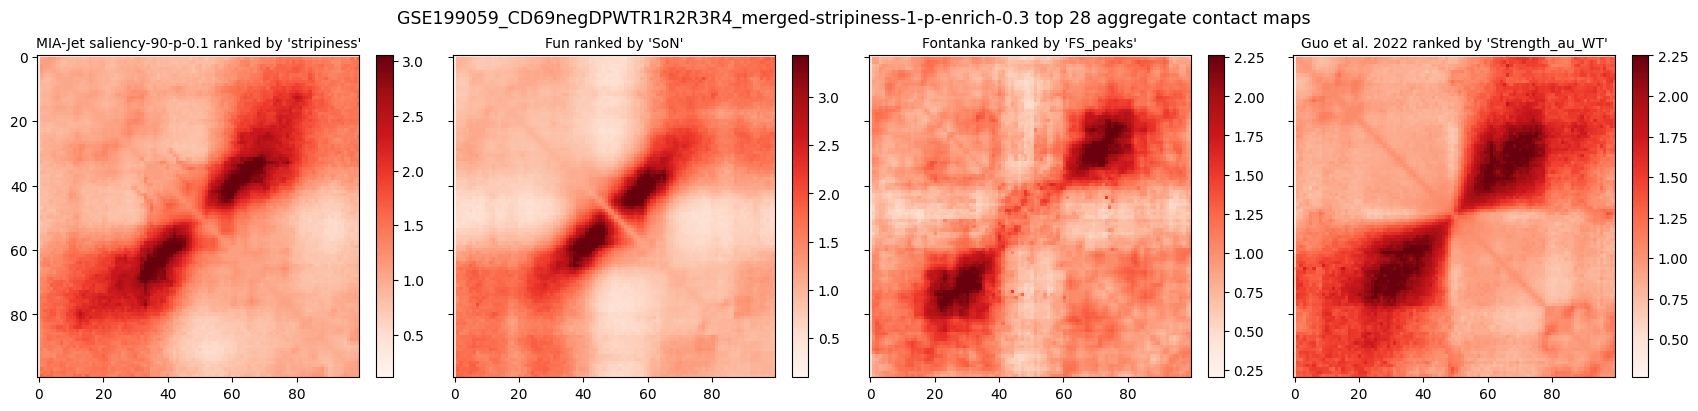

In [22]:
titles = [f"{names[i]} ranked by '{ranking_col[i]}'" for i in range(len(names))]

plot_n_hic(
    agg_map,
    suptitle=f"{data_name} top {N} aggregate contact maps",
    resolution=None,
    cmap_label=None,
    titles=titles,
    cmap='Reds',
    show=True, 
    vmax=vmaxes,
    ppr=4,
    savepath=f"{save_path}/{data_name}_{result_type}_topN_agg_map-{data_type}.png"
)

In [23]:
stat = "max"
window_plus_minus = int(10e3) # 10 kb
chipseq_resolution = 10000 # 10kb resolution

intervals = []

for t in top_bed_tables:
    df_interval = t[["unique_id", "chrom"]].copy()
    df_interval["midpoint"] = (t["start"] + t["end"]) / 2
    df_interval["start"] = df_interval["midpoint"] - window_plus_minus
    df_interval["end"] = df_interval["midpoint"] + window_plus_minus

    intervals.append(df_interval.reset_index(drop=True))

In [24]:
chipseq_values = extract_chipseq_values(chip_files, intervals, f_chrom_sizes, common_chroms, names)

track was not included in <_io.TextIOWrapper name='/nfs/turbo/umms-minjilab/processing/genomes/mm9/mm9.chrom.sizes' mode='r' encoding='UTF-8'>


No jets called for chromosome chr1 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr4 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr7 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr10 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr12 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr15 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr17 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr19 by MIA-Jet saliency-90-p-0.1


chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo e

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chrM is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chrM by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr7 by Fun
No jets called for chromosome chr13 by Fun
No jets called for chromosome chr14 by Fun
No jets called for chromosome chr18 by Fun
No jets called for chromosome chr19 by Fun
No jets called for chromosome chrY by Fun
No jets called for chromosome chrM by Fun
No jets called for chromosome chr9 by Fontanka
No jets called for chromosome chr13 by Fontanka
No jets called for chromosome chr19 by Fontanka
No jets called for chromosome chrY by Fontanka
No jets called for chromosome chrM by Fontanka
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr8 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
No jets cal

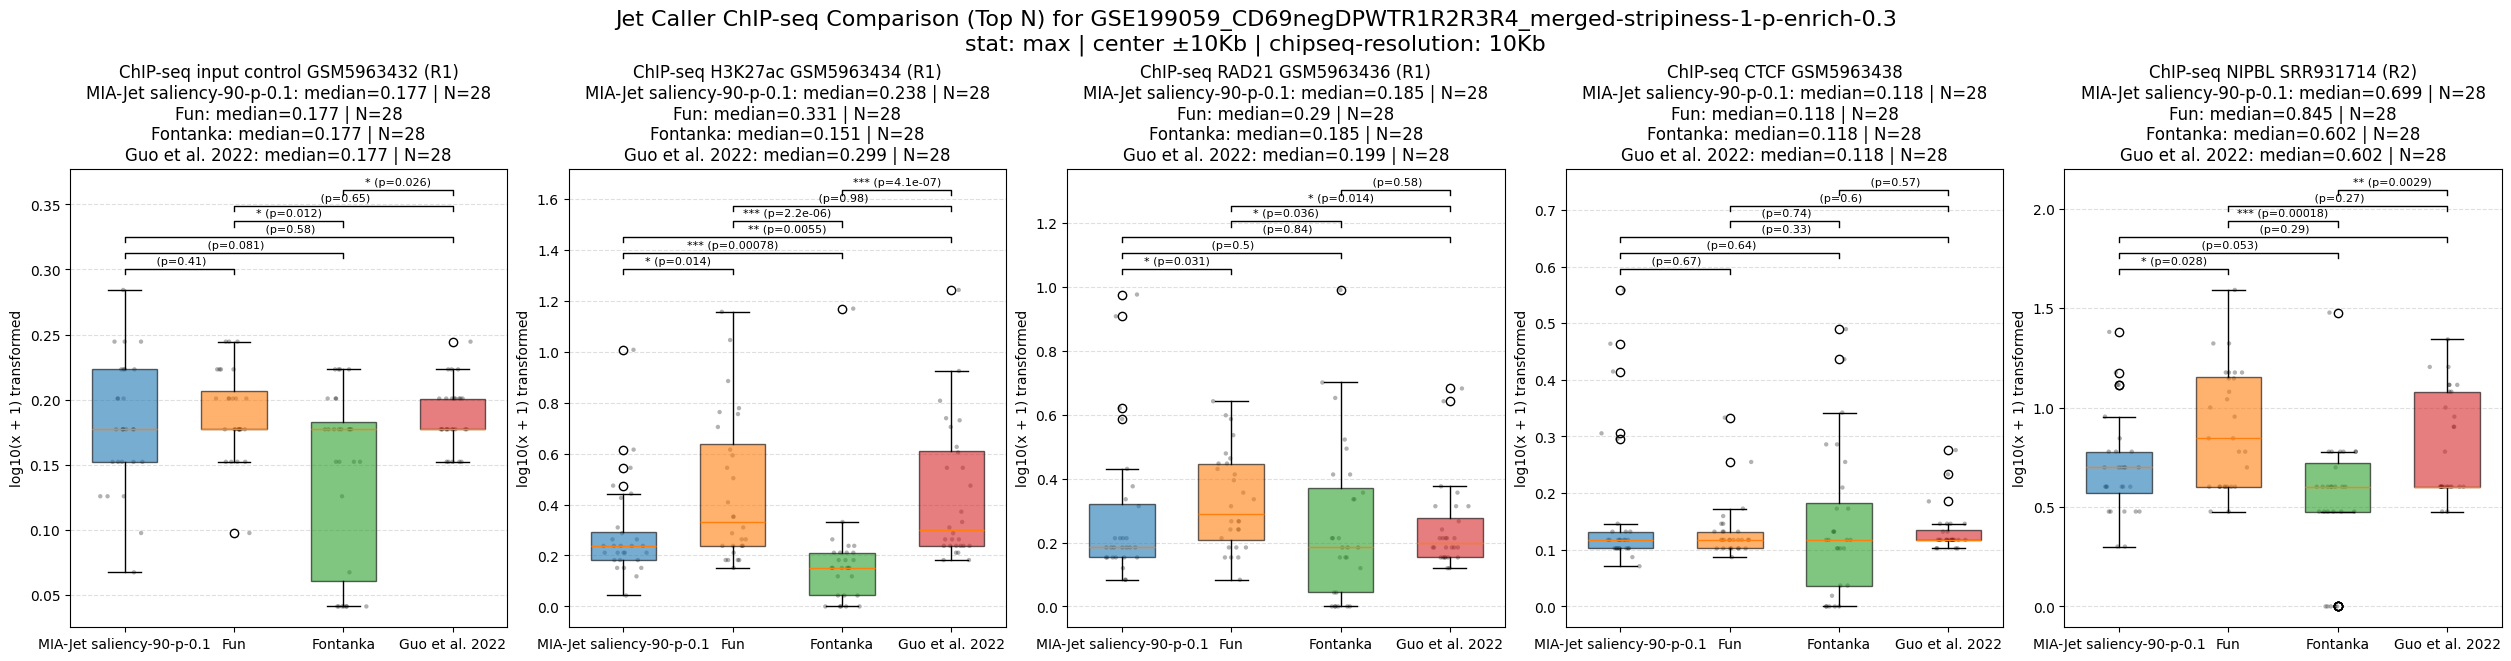

In [25]:
n_exp = len(chip_names)
n_callers = len(names)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1, n_exp, layout='constrained', figsize=(5 * len(chip_names), 6.5))

for i in range(len(chip_names)):
    chip_name = chip_names_abrev[i]

    datum = chipseq_values[i]
    boxplot_data = [list(x.values()) for x in datum]

    clean_data = [np.array(vals)[~np.isnan(vals)] for vals in boxplot_data]

    # log transform
    clean_data = [np.clip(vals, 0, None) for vals in clean_data]  # clip negative values to zero
    clean_data = [np.log10(vals + 1) for vals in clean_data]
    exp_counts = [len(vals) for vals in clean_data]
    positions = np.arange(1, n_callers + 1)

    # make boxplot titles
    title_boxstat = title_boxplot(chip_names[i], names, clean_data)

    # add pairwise significance 
    add_pairwise_sig(ax[i], positions, clean_data)

    bp = ax[i].boxplot(clean_data, patch_artist=True, positions=positions, widths=0.6)

    # color each box
    for patch, col in zip(bp['boxes'], colors[:n_callers]):
        patch.set_facecolor(col)
        patch.set_alpha(0.6)

    # jittered scatter on top
    for j, vals in enumerate(clean_data):
        y = np.array(vals)
        x = np.full_like(y, positions[j], dtype=float) + np.random.normal(0, 0.08, size=len(y))
        ax[i].scatter(x, y, alpha=0.3, s=10, color='k', edgecolor='none')

    # x-tick labels
    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(names, rotation=0)

    ax[i].set_ylabel("log10(x + 1) transformed")
    
    ax[i].set_title(title_boxstat)
    ax[i].grid(axis='y', linestyle='--', alpha=0.4)


fig.suptitle(f"Jet Caller ChIP-seq Comparison (Top N) for {data_name}\n"
             f"stat: {stat} | center ±{genomic_labels(window_plus_minus)} | chipseq-resolution: {genomic_labels(chipseq_resolution)}", fontsize=16)

plt.savefig(f"{save_path}/{data_name}_{result_type}_chipseq_comparison-topN.png", dpi=300)

plt.show()

In [26]:
method_names = [f"{names[i]} ranked by '{ranking_col[i]}'" for i in range(len(names))]

for idx in range(len(names)):
    
    suptitle = method_names[idx]

    # Select top jets according to "jet_saliency" column
    top_n = N  
    # 1) get the original row‐indices of the top N
    top_idx = df_stack[idx].nlargest(top_n, ranking_col[idx]).index

    # 2) subset the DataFrame (and only then reset if you like)
    sampled_df_stack = df_stack[idx].loc[top_idx].reset_index(drop=True)

    # 3) subset the array with those SAME indices
    sampled_stack = stacks[idx][top_idx]

    titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
    titles += f" ({ranking_col[idx]}: " + sampled_df_stack[ranking_col[idx]].map(lambda x : f"{x:.3g}") + ")"
    titles += f"\nResolution: " + pd.Series([genomic_labels(r, N=1) for r in resolutions[idx]]).astype(str) 
    titles = titles.tolist()

    genomic_shift = sampled_df_stack["start"].to_numpy()

    vmaxes = [np.percentile(s, 99) for s in sampled_stack]

    plot_n_hic(sampled_stack, 
            titles=titles, 
            resolution=resolutions[idx],
            suptitle=f"{suptitle} N={top_n}\n{data_type} {normalization}", 
            show=False, 
            genomic_shift=genomic_shift, 
            cmap_label=None, 
            vmax=vmaxes,
            ppr=6,
            savepath=f"{save_path}/{data_name}_{result_type}_individual-topN_{data_type}_{names[idx]}_negate-{ranking_col[idx]}.png",
            cmap="Reds")

## ALL Aggregate plots

In [27]:
agg_map = []
vmaxes = []
stacks = []
df_stack = []
resolutions = []
chipseq_stacks = []
# for each 

# resolutions = []
for bed_df in bed_tables:
    # Get pileups for each bed_df
    s, d, r = get_pileups_dynamic_resolution(
        hic_file=hic_file,
        bed_df_in=bed_df,
        expected_stack_size=expected_stack_size,
        chrom_sizes=chrom_sizes,
        chromosomes='all',
        window_range=(None, None),
        data_type=data_type,
        normalization=normalization,
        sort=True,
        verbose=True
    )

    # Remove centromeres and resize square stacks
    s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

    if data_type == "observed":
        s = np.log10(s + 1) # log transform for visualization

    a = np.mean(s, axis=0)
    vmaxes.append(np.percentile(a, 99))  # store the 99th percentile for color scaling
    agg_map.append(a)  # average over all stacks
    stacks.append(s)  # store the stacks for later use
    df_stack.append(d)  # store the DataFrame for later use
    resolutions.append(r)  # store the resolution for later use

Retrieving pileups: 100%|██████████| 37/37 [00:01<00:00, 30.02it/s]


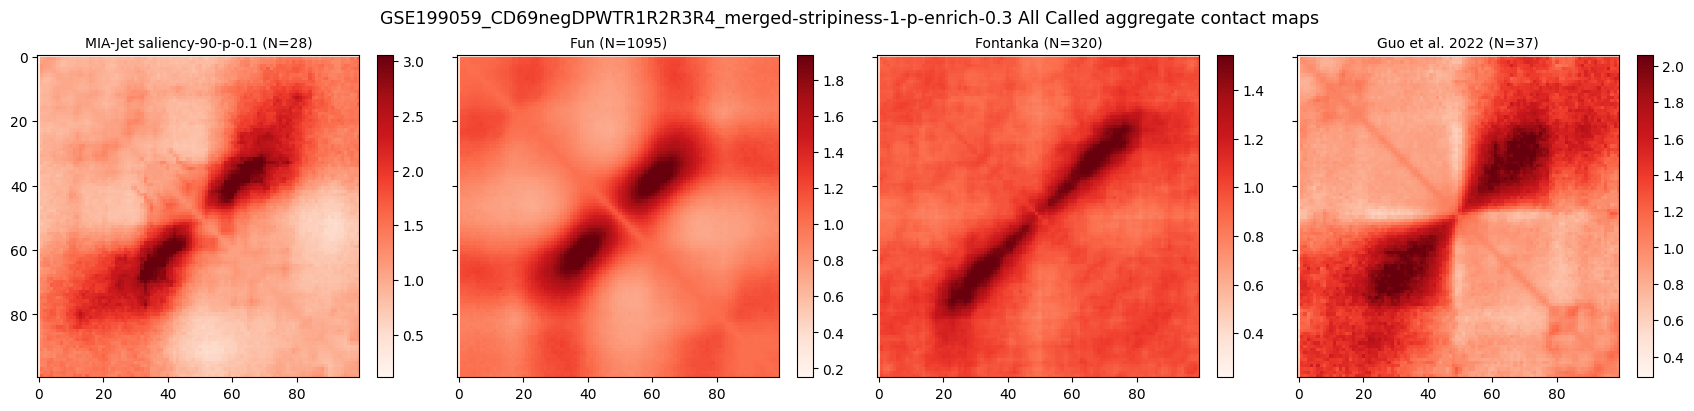

In [28]:
titles = [f"{names[i]} (N={len(df_stack[i])})" for i in range(len(names))]

plot_n_hic(
    agg_map,
    suptitle=f"{data_name} All Called aggregate contact maps",
    resolution=None,
    cmap_label=None,
    titles=titles,
    cmap='Reds',
    show=True, 
    vmax=vmaxes,
    ppr=4,
    savepath=f"{save_path}/{data_name}_all_agg_map-{data_type}.png"
)

In [29]:
stat = "max"
window_plus_minus = int(10e3) # 10 kb
chipseq_resolution = 10000 # 10kb resolution

intervals = []

for t in bed_tables:
    df_interval = t[["unique_id", "chrom"]].copy()
    df_interval["midpoint"] = (t["start"] + t["end"]) / 2
    df_interval["start"] = df_interval["midpoint"] - window_plus_minus
    df_interval["end"] = df_interval["midpoint"] + window_plus_minus

    intervals.append(df_interval.reset_index(drop=True))

In [30]:
chipseq_values = extract_chipseq_values(chip_files, intervals, f_chrom_sizes, common_chroms, names)

track was not included in <_io.TextIOWrapper name='/nfs/turbo/umms-minjilab/processing/genomes/mm9/mm9.chrom.sizes' mode='r' encoding='UTF-8'>


No jets called for chromosome chr1 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr4 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr7 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr10 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr12 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr15 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr17 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr19 by MIA-Jet saliency-90-p-0.1


chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph.

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.b

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph.

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No 

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chrM is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chrM by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chrY by Fun
No jets called for chromosome chrM by Fun
No jets called for chromosome chrY by Fontanka
No jets called for chromosome chrM by Fontanka
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
No jets called for chromosome chrM by Guo et al. 2022


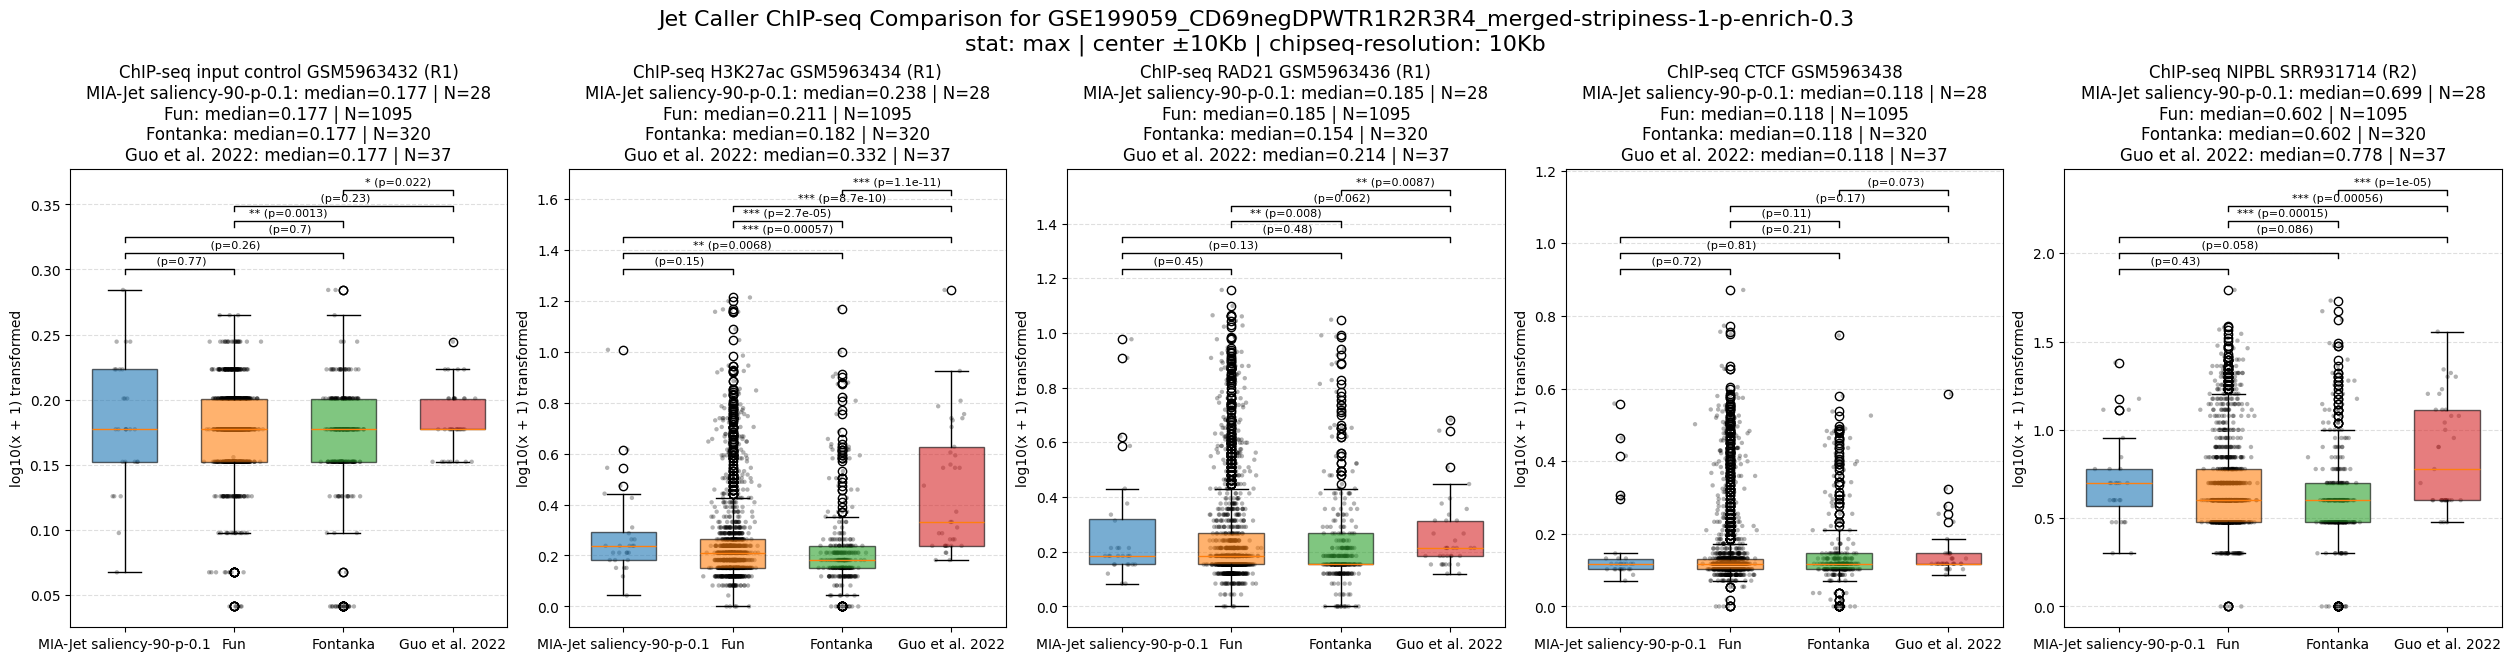

In [31]:
n_exp = len(chip_names)
n_callers = len(names)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1, n_exp, layout='constrained', figsize=(5 * len(chip_names), 6.5))

for i in range(len(chip_names)):
    chip_name = chip_names_abrev[i]

    datum = chipseq_values[i]
    boxplot_data = [list(x.values()) for x in datum]

    clean_data = [np.array(vals)[~np.isnan(vals)] for vals in boxplot_data]

    # log transform
    clean_data = [np.clip(vals, 0, None) for vals in clean_data]  # clip negative values to zero
    clean_data = [np.log10(vals + 1) for vals in clean_data]
    exp_counts = [len(vals) for vals in clean_data]
    positions = np.arange(1, n_callers + 1)

    # make boxplot titles
    title_boxstat = title_boxplot(chip_names[i], names, clean_data)

    # add pairwise significance 
    add_pairwise_sig(ax[i], positions, clean_data)

    bp = ax[i].boxplot(clean_data, patch_artist=True, positions=positions, widths=0.6)

    # color each box
    for patch, col in zip(bp['boxes'], colors[:n_callers]):
        patch.set_facecolor(col)
        patch.set_alpha(0.6)

    # jittered scatter on top
    for j, vals in enumerate(clean_data):
        y = np.array(vals)
        x = np.full_like(y, positions[j], dtype=float) + np.random.normal(0, 0.08, size=len(y))
        ax[i].scatter(x, y, alpha=0.3, s=10, color='k', edgecolor='none')

    # x-tick labels
    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(names, rotation=0)

    ax[i].set_ylabel("log10(x + 1) transformed")
    
    ax[i].set_title(title_boxstat)
    ax[i].grid(axis='y', linestyle='--', alpha=0.4)


fig.suptitle(f"Jet Caller ChIP-seq Comparison for {data_name}\n"
             f"stat: {stat} | center ±{genomic_labels(window_plus_minus)} | chipseq-resolution: {genomic_labels(chipseq_resolution)}", fontsize=16)

plt.savefig(f"{save_path}/{data_name}_{result_type}_chipseq_comparison-all.png", dpi=300)

plt.show()

## Confirm NIPBL ChIP-seq mapping

In [32]:
# chip_files[-1]

In [33]:
# # First, lets confirm that the ChIP-seq mapping was successful
# bg = BedGraph(f_chrom_sizes, chip_files[-1])

In [34]:
# # Region in paper is chr17:
# region_start = 67500e3 # # 67.5 Mb or 67,000 kb
# region_end = 71500e3 # 71.5 Mb or 71,000 kb
# bg.load_chrom_data('chr17')    

In [35]:
# starts = np.arange(region_start, region_end + int(10e3), int(10e3))
# ends = starts + int(10e3)

# intervals = pd.DataFrame({
#     "chrom": "chr17",
#     "start": starts,
#     "end": ends
# }).values.tolist()

In [36]:
# region_max = bg.stats(stat="max", intervals=intervals)
# region_mean = bg.stats(stat="mean", intervals=intervals)
# # region_cov = bg.stats(stat="coverage", intervals=intervals)

In [37]:
# fig, ax = plt.subplots(2, 1, figsize=(12, 2), layout='constrained', sharex=True)

# ax[0].bar(starts, region_max, width=int(10e3), label="max", color='red')
# ax[1].bar(starts, region_mean, width=int(10e3), label="mean", color='blue')
# # ax[2].bar(starts, region_cov, width=chipseq_resolution, label="coverage")

# # show common legend NOW:
# fig.legend(loc='upper right')

# fig.suptitle(f"{chip_names[-1]} {int(10e3)}bp chr17:67.5mb-71.5mb", fontsize=16)

# format_ticks(ax[0], y=False)

# plt.show()

## Reading BedGraph for Venn Diagrams

In [38]:
stat = "max"
window_plus_minus = int(10e3) # 10 kb
chipseq_resolution = 10000 # 10kb resolution

intervals = []

for t in bed_tables:
    df_interval = t[["unique_id", "chrom"]].copy()
    df_interval["midpoint"] = (t["start"] + t["end"]) / 2
    df_interval["start"] = df_interval["midpoint"] - window_plus_minus
    df_interval["end"] = df_interval["midpoint"] + window_plus_minus

    intervals.append(df_interval.reset_index(drop=True))

In [39]:
# # Confirm it has chrX data!
# temp = pd.read_csv("/nfs/turbo/umms-minjilab/processing/results/SRR931714/dp_thymocytes_NIPBL_SRR931714_miseq.q30.nr.sorted.bedgraph", names=["chrom", "start", "end", "value"], sep="\t")
# temp = temp.loc[temp["chrom"] == "chrX"].reset_index(drop=True)
# temp

In [40]:
chipseq_values = extract_chipseq_values(chip_files, intervals, f_chrom_sizes, common_chroms, names)

track was not included in <_io.TextIOWrapper name='/nfs/turbo/umms-minjilab/processing/genomes/mm9/mm9.chrom.sizes' mode='r' encoding='UTF-8'>


No jets called for chromosome chr1 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr4 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr7 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr10 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr12 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr15 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr17 by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chr19 by MIA-Jet saliency-90-p-0.1


chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph.

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.b

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph.

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chr1 is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fun
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chrY by Fontanka
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
Chromosome chrM not found in /nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph. Skipping...
No 

chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is already loaded
chrM is already loaded
chr1 is already loaded
chr2 is already loaded
chr3 is already loaded
chr4 is already loaded
chr5 is already loaded
chr6 is already loaded
chr7 is already loaded
chr8 is already loaded
chr9 is already loaded
chr10 is already loaded
chr11 is already loaded
chr12 is already loaded
chr13 is already loaded
chr14 is already loaded
chr15 is already loaded
chr16 is already loaded
chr17 is already loaded
chr18 is already loaded
chr19 is already loaded
chrX is already loaded
chrY is alread

No jets called for chromosome chrY by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chrM by MIA-Jet saliency-90-p-0.1
No jets called for chromosome chrY by Fun
No jets called for chromosome chrM by Fun
No jets called for chromosome chrY by Fontanka
No jets called for chromosome chrM by Fontanka
No jets called for chromosome chr7 by Guo et al. 2022
No jets called for chromosome chr15 by Guo et al. 2022
No jets called for chromosome chr18 by Guo et al. 2022
No jets called for chromosome chrX by Guo et al. 2022
No jets called for chromosome chrY by Guo et al. 2022
No jets called for chromosome chrM by Guo et al. 2022


In [41]:
chip_names

['ChIP-seq input control GSM5963432 (R1)',
 'ChIP-seq H3K27ac GSM5963434 (R1)',
 'ChIP-seq RAD21 GSM5963436 (R1)',
 'ChIP-seq CTCF GSM5963438',
 'ChIP-seq NIPBL SRR931714 (R2)']

In [42]:
len(chipseq_values) # number of chip-seq files

5

In [43]:
len(chipseq_values[0]) # number of jet callers

4

In [44]:
chipseq_values[0][0] # a dictionary of values

{'chr2_1254_12': 0.75622,
 'chr2_3_11': 0.50414,
 'chr2_94_6': 0.50414,
 'chr2_751_17': 0.75622,
 'chr2_7701_0': 0.67219,
 'chr2_131_10': 0.58817,
 'chr3_7_14': 0.50414,
 'chr3_10_14': 0.92427,
 'chr5_109_0': 0.42012,
 'chr5_1005_13': 0.58817,
 'chr6_8_17': 0.16805,
 'chr8_2_8': 0.42012,
 'chr8_899_10': 0.50414,
 'chr9_5_18': 0.42012,
 'chr11_959_11': 0.58817,
 'chr11_3117_3': 0.42012,
 'chr11_13_18': 0.50414,
 'chr13_10_9': 0.42012,
 'chr13_3_19': 0.67219,
 'chr13_1912_5': 0.3361,
 'chr14_2_13': 0.25207,
 'chr14_18_8': 0.67219,
 'chr14_132_14': 0.75622,
 'chr16_1190_6': 0.67219,
 'chr16_2139_3': 0.50414,
 'chr18_79_15': 0.50414,
 'chrX_69_8': 0.3361,
 'chrX_326_8': 0.3361}

## Call AB compartments

Update: Difficult to plot A/B compartments because we may need to flip the eigenvector based on open chromatin

In [45]:
# from cooltools.api.eigdecomp import cis_eig

In [46]:
# eigvecs = []
# for c in tqdm(common_chroms):

#     A = read_hic_file(hic_file, chrom=c, resolution=chipseq_resolution, positions="all", 
#                       normalization=normalization, data_type=data_type, verbose=False)
    
#     _, v = cis_eig(A, n_eigs=1)

#     eigvecs.append(v[0, :])

## Intersection

For each partition
1. Aggregate plots (all cell lines)
2. Boxplots (DP thymocytes only)
3. Correlation (all cell lines, for only intersection partition)

In [47]:
buffer_radius = 3 * resolution  # 5 bins
iou_threshold = 0  # ANY overlap

In [48]:
results = pd.DataFrame(index=names, columns=names, dtype=int).fillna(0)
unique_identifiers = []
name_pairs = []
# fill main diagonal with the total number of jets from each method
for n in names:
    results.loc[n, n] = len(table_dict[n])

for n1, n2 in itertools.combinations(names, 2):

    print("-" * 20)
    print(f"Comparing {n1} and {n2}...")

    genome_wide_overlap = 0
    identifiers = []

    for chrom in common_chroms:
        # IOU method is per-chromosome so filter each table by chromosome
        t1 = position_dict[n1].loc[position_dict[n1]["chrom"] == chrom]
        t2 = position_dict[n2].loc[position_dict[n2]["chrom"] == chrom]

        # Summary tables to get the number of jets called by each method
        s1 = table_dict[n1].loc[table_dict[n1]["chrom"] == chrom]
        s2 = table_dict[n2].loc[table_dict[n2]["chrom"] == chrom]

        # Compute the pairs of jets in each direction
        pairs12 = match_by_iou(t1, t2, buffer_radius, iou_threshold)
        pairs21 = match_by_iou(t2, t1, buffer_radius, iou_threshold)

        # Construct graph and find unique pairs
        pairs = unique_pairs(pairs12, pairs21, method="optimal")

        # print(f"* {chrom}: {len(pairs)} pairs between {n1} ({len(s1)}) and {n2} ({len(s2)})")

        genome_wide_overlap += len(pairs)
        identifiers += pairs # extend the list

    # Update reuslts table
    results.loc[n1, n2] = genome_wide_overlap
    results.loc[n2, n1] = genome_wide_overlap  # symmetric

    unique_identifiers.append(identifiers)
    name_pairs.append((n1, n2))
    
print("Genome-wide overlaps:")
results

--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fun...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Fontanka...
--------------------
Comparing MIA-Jet saliency-90-p-0.1 and Guo et al. 2022...
--------------------
Comparing Fun and Fontanka...
--------------------
Comparing Fun and Guo et al. 2022...
--------------------
Comparing Fontanka and Guo et al. 2022...
Genome-wide overlaps:


MIA-Jet saliency-90-p-0.1     Fun  Fontanka  \
MIA-Jet saliency-90-p-0.1                       28.0    27.0       6.0   
Fun                                             27.0  1095.0     103.0   
Fontanka                                         6.0   103.0     320.0   
Guo et al. 2022                                  7.0    30.0       8.0   

                           Guo et al. 2022  
MIA-Jet saliency-90-p-0.1              7.0  
Fun                                   30.0  
Fontanka                               8.0  
Guo et al. 2022                       37.0

In [49]:
# Collect plot data
agg_map_pairs = [] # aggregate contact map data
jet_strength_pairs = [] # jet strength correlation data
boxplot_pairs = [] # boxplot data
for (n1, n2), pairs in zip(name_pairs, unique_identifiers):

    # vectorize the function (so it applies element-wise)
    safe_convert = np.vectorize(safe_int)

    # Construct bed dataframes from the unique identifier pairs 
    df_intersections = []

    uid1 = np.array(pairs)[:, 0]  # unique identifiers from n1
    uid2 = np.array(pairs)[:, 1]  # unique identifiers from n2

    uid1 = safe_convert(uid1)
    uid2 = safe_convert(uid2)

    df1 = pd.DataFrame({"unique_id" : uid1,})
    df2 = pd.DataFrame({"unique_id" : uid2,})

    # Lets do a merge of the summary table and the unique identifiers
    # We may now use any of df1 OR df2 (any – shouldn't matter) to construct the bed dataframe
    # to plot the aggregate jet positions

    # Use n1
    A_name = n1
    B_name = n2
    # Summary dataframe
    df_A = table_dict[n1]
    df_B = table_dict[n2]
    # IDs from the returned unique pairs
    # These will be used to merge to extract the relevant positions
    df_id = df1
    df_id_alt = df2
    # Expanded dataframe 
    df_pos_A = position_dict[n1].copy()
    df_pos_B = position_dict[n2].copy()

    # These are the "main" summary dataframes
    # That should be sufficien to plot the aggregate contact maps and boxplots
    df_intersection = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_diff_A = df_A[~df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_diff_B = df_B[~df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    # Assertions to ensure that the intersection and difference cover the whole table
    assert len(df_intersection) + len(df_diff_A) == len(df_A), "The intersection and difference should cover the whole table"
    assert len(df_intersection) + len(df_diff_B) == len(df_B), "The intersection and difference should cover the whole table"

    # BOXPLOT
    table_frames = [df_diff_A, df_intersection, df_diff_B] 
    table_names = [f"{A_name} only", f"{A_name} & {B_name}", f"{B_name} only"]
    # pick A_idx for the first two groups, B_idx for the last one
    # this is the convention established above (i.e. if intersection, then n1 takes preference)
    # source means jet caller
    source_idxs  = [names.index(n1), names.index(n1), names.index(n2)]


    boxplot_vals = []
    for table_df, src in zip(table_frames, source_idxs):
        boxplot_exp = []
        # now loop over each chipseq file (outer dim)
        for chip_vals in chipseq_values:
            # pick the dict for this caller (jet caller)
            chip_exp = chip_vals[src]
            # extract in order values for these unique_ids
            vals = table_df["unique_id"].apply(lambda uid: chip_exp.get(uid, np.nan)).values
            boxplot_exp.append(vals)
        boxplot_vals.append(boxplot_exp)

    boxplot_pairs.append(boxplot_vals)

    # CORRELATION 
    # Lets get the jet strength correlation between different jet callers, which is only possible for the intersection
    # Since these are the jets that are called by both methods, enabling correlation plots
    df_intersection_A = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_intersection_B = df_B[df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    A_idx = names.index(n1)
    B_idx = names.index(n2)
    # Construct dictionaries for jet strengths
    strength_A = df_A.set_index("unique_id")[ranking_col[A_idx]].to_dict()
    strength_B = df_B.set_index("unique_id")[ranking_col[B_idx]].to_dict()

    # extract in the same order
    js_A = [strength_A.get(u, np.nan) for u in uid1]
    js_B = [strength_B.get(u, np.nan) for u in uid2]

    jet_strength_pairs.append(np.array([js_A, js_B]))

    # AGGREGATE CONTACT MAPS
    # Lets get the positions, which is better to plot the individual Hi-C diagnostic plots
    # These diagnostic plots are meant to confirm that the overlapping parameters are good
    df_pos_intersection = df_pos_A[df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_pos_diff_A = df_pos_A[~df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_pos_diff_B = df_pos_B[~df_pos_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    plot_overlap_diagnostic(
        hic_file=hic_file,
        plot_chrom=common_chroms[0],  
        resolution=resolution,
        data_type="observed",
        normalization="VC_SQRT",
        A_name=A_name,
        B_name=B_name,
        df_pos_A=df_pos_A,
        df_pos_B=df_pos_B,
        df_pos_intersection=df_pos_intersection,
        df_pos_diff_A=df_pos_diff_A,
        df_pos_diff_B=df_pos_diff_B,
        save_path=save_path,
        data_name=data_name
    )

    # Make bed files to get stacks
    bed_intersection = generate_bed_2(df_intersection, df_pos_intersection, eps=500e3, fraction=1.5)
    bed_diff_A = generate_bed_2(df_diff_A, df_pos_diff_A, eps=500e3, fraction=1.5)
    bed_diff_B = generate_bed_2(df_diff_B, df_pos_diff_B, eps=500e3, fraction=1.5)

    chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

    bed_frames = [bed_diff_A, bed_intersection, bed_diff_B]
    bed_names = [f"{A_name} only", f"{A_name} & {B_name}", f"{B_name} only"]

    agg_map = []
    # resolutions = []
    for bed_df, name in zip(bed_frames, bed_names):
        # Get pileups for each bed_df
        s, d, r = get_pileups_dynamic_resolution(
            hic_file=hic_file,
            bed_df_in=bed_df,
            expected_stack_size=expected_stack_size,
            chrom_sizes=chrom_sizes,
            chromosomes='all',
            window_range=(None, None),
            data_type=data_type,
            normalization=normalization,
            sort=True,
            verbose=True
        )

        # Remove centromeres and resize square stacks
        s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

        if data_type == "observed":
            s = np.log10(s + 1) # log transform for visualization

        agg_map.append(np.mean(s, axis=0))  # average over all stacks
        # resolutions.append(r)

    agg_map_pairs.append(agg_map)

Retrieving pileups: 100%|██████████| 29/29 [00:00<00:00, 29.08it/s]


In [50]:
agg_map_pairs = np.array(agg_map_pairs)

agg_map_pairs.shape 
# number of pair combinations, (A only, A&B, B only), stack size, stack size

(6, 3, 100, 100)

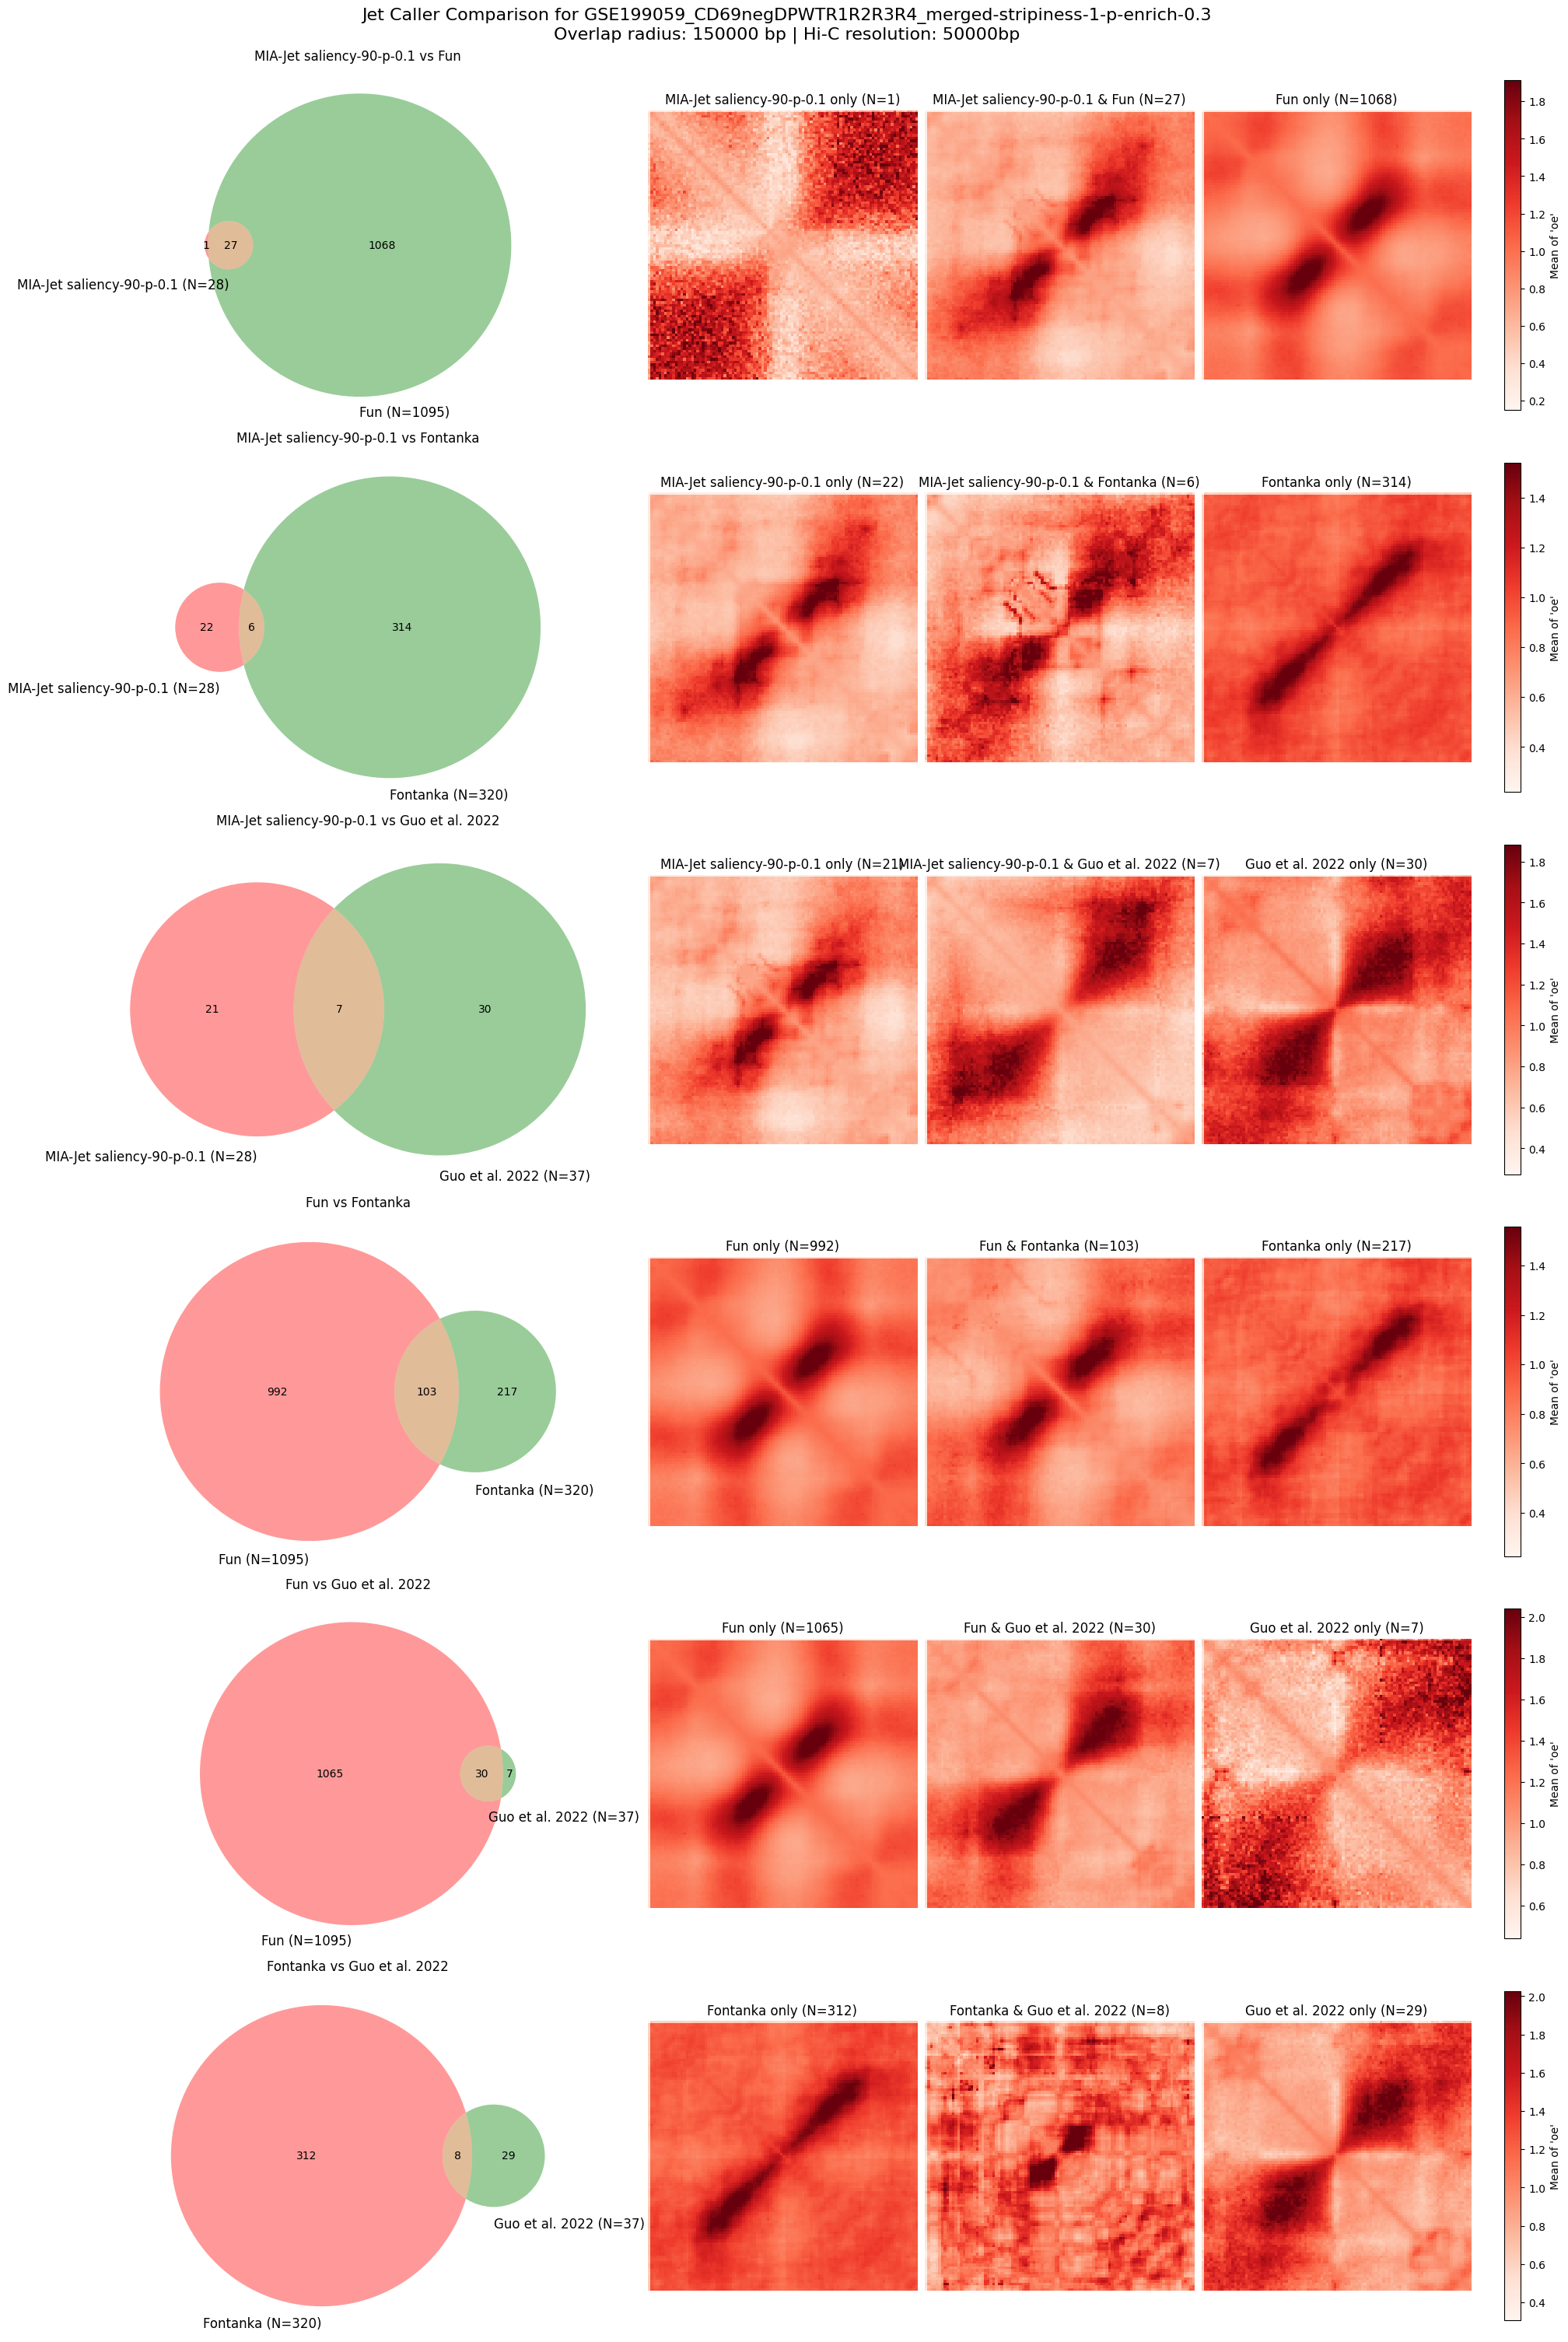

In [51]:
# every pairwise combination of table names
pairs = list(itertools.combinations(names, 2))
num_pairs = len(pairs)

fig, axes = plt.subplots(num_pairs, 4, figsize=(5*4, 5*num_pairs), layout='constrained', width_ratios=[2, 1, 1, 1])

for row, (A, B) in enumerate(pairs):
    # compute overlaps as before
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter   = results.loc[A, B]
    only_A  = total_A - inter
    only_B  = total_B - inter

    # column 0: the Venn
    ax = axes[row, 0]
    venn2(subsets=(int(only_A), int(only_B), int(inter)),
          set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
          ax=ax)
    ax.set_title(f"{A} vs {B}")

    # columns 1–3: the three imshows
    # agg_map_pairs.shape == (n_pairs, 3, H, W)
    titles = [f"{A} only", f"{A} & {B}", f"{B} only"]
    counts = [int(only_A), int(inter), int(only_B)]
    row_imgs = agg_map_pairs[row]
    row_vmax = max(np.percentile(img, 99) for img in row_imgs)
    for col_idx in range(3):
        ax = axes[row, col_idx+1]
        img = agg_map_pairs[row, col_idx]
        im = ax.imshow(img, cmap="Reds", interpolation="none", vmax=np.percentile(img, 99))
        ax.set_title(f"{titles[col_idx]} (N={counts[col_idx]})")
        ax.axis('off')
    fig.colorbar(im, ax=axes[row, 1:], fraction=0.02, pad=0.04, label=f"Mean of '{data_type}'")


fig.suptitle(f"Jet Caller Comparison for {data_name}\nOverlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution}bp", fontsize=16)

plt.savefig(f"{save_path}/{data_name}_{result_type}_venn_diagram-agg.png", dpi=300)

plt.show()

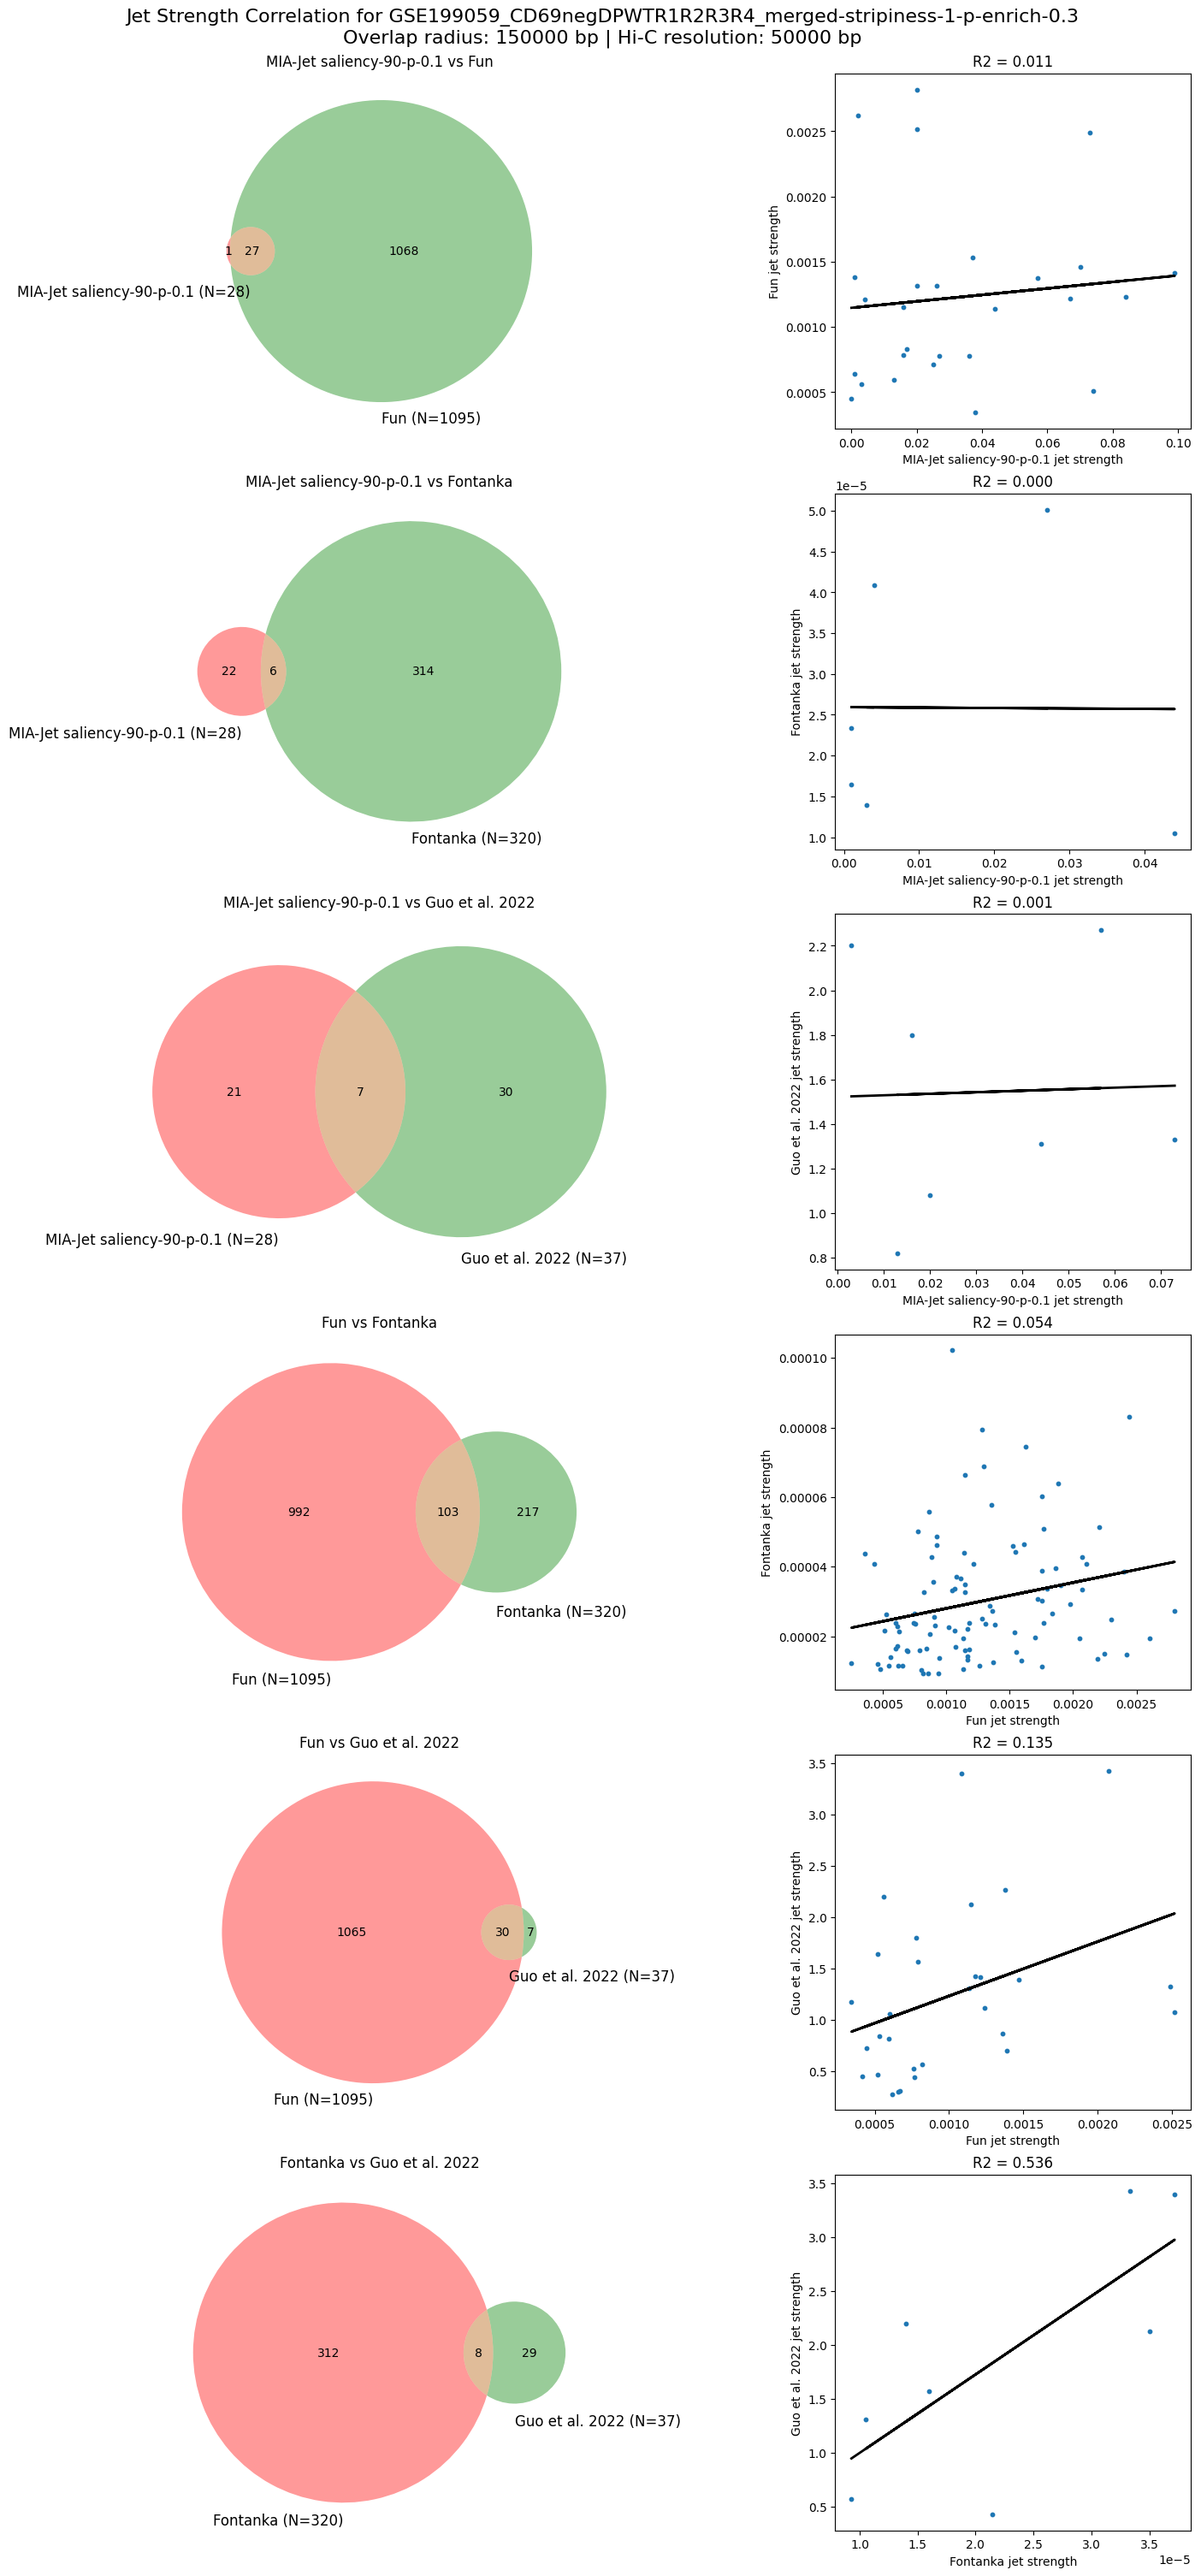

In [52]:
from scipy.stats import linregress

pairs = list(itertools.combinations(names, 2))
num_pairs = len(pairs)

fig, axes = plt.subplots(num_pairs, 2, figsize=(14, 5 * num_pairs), constrained_layout=True, width_ratios=[2, 1])

for row, (A, B) in enumerate(pairs):
    # compute overlap counts
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter   = results.loc[A, B]
    only_A  = total_A - inter
    only_B  = total_B - inter

    # Venn Diagram
    ax0 = axes[row, 0] if num_pairs > 1 else axes[0]
    venn2(
        subsets=(int(only_A), int(only_B), int(inter)),
        set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
        ax=ax0
    )
    ax0.set_title(f"{A} vs {B}")

    # Correlation plots
    ax1 = axes[row, 1] if num_pairs > 1 else axes[1]
    js = jet_strength_pairs[row]      # shape (2, N)
    x  = np.array(js[0], dtype=float)  # A strengths
    y  = np.array(js[1], dtype=float)  # B strengths

    # fit line and compute R2
    result = linregress(x, y)
    y_fit = result.intercept + result.slope * x
    r2 = result.rvalue ** 2

    # plot
    ax1.scatter(x, y, alpha=1, s=10)
    ax1.plot(x, y_fit, color='k', linewidth=2, )
    ax1.set_box_aspect(1)
    ax1.set_xlabel(f"{A} jet strength")
    ax1.set_ylabel(f"{B} jet strength")
    ax1.set_title(f"R2 = {r2:.3f}")

# overall title
fig.suptitle(f"Jet Strength Correlation for {data_name}\n" 
             f"Overlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution} bp", 
             fontsize=16)

plt.savefig(f"{save_path}/{data_name}_{result_type}_venn_diagram-line.png", dpi=300)

plt.show()

In [53]:
len(boxplot_pairs) # for the number of pairs

6

In [54]:
name_pairs

[('MIA-Jet saliency-90-p-0.1', 'Fun'),
 ('MIA-Jet saliency-90-p-0.1', 'Fontanka'),
 ('MIA-Jet saliency-90-p-0.1', 'Guo et al. 2022'),
 ('Fun', 'Fontanka'),
 ('Fun', 'Guo et al. 2022'),
 ('Fontanka', 'Guo et al. 2022')]

In [55]:
len(boxplot_pairs[0]) # for the A only, A&B, B Only

3

In [56]:
len(boxplot_pairs[0][0]) # for the number of chip-seq experiments

5

In [57]:
chip_names_abrev

['Input', 'H3K27ac', 'RAD21', 'CTCF', 'NIPBL']

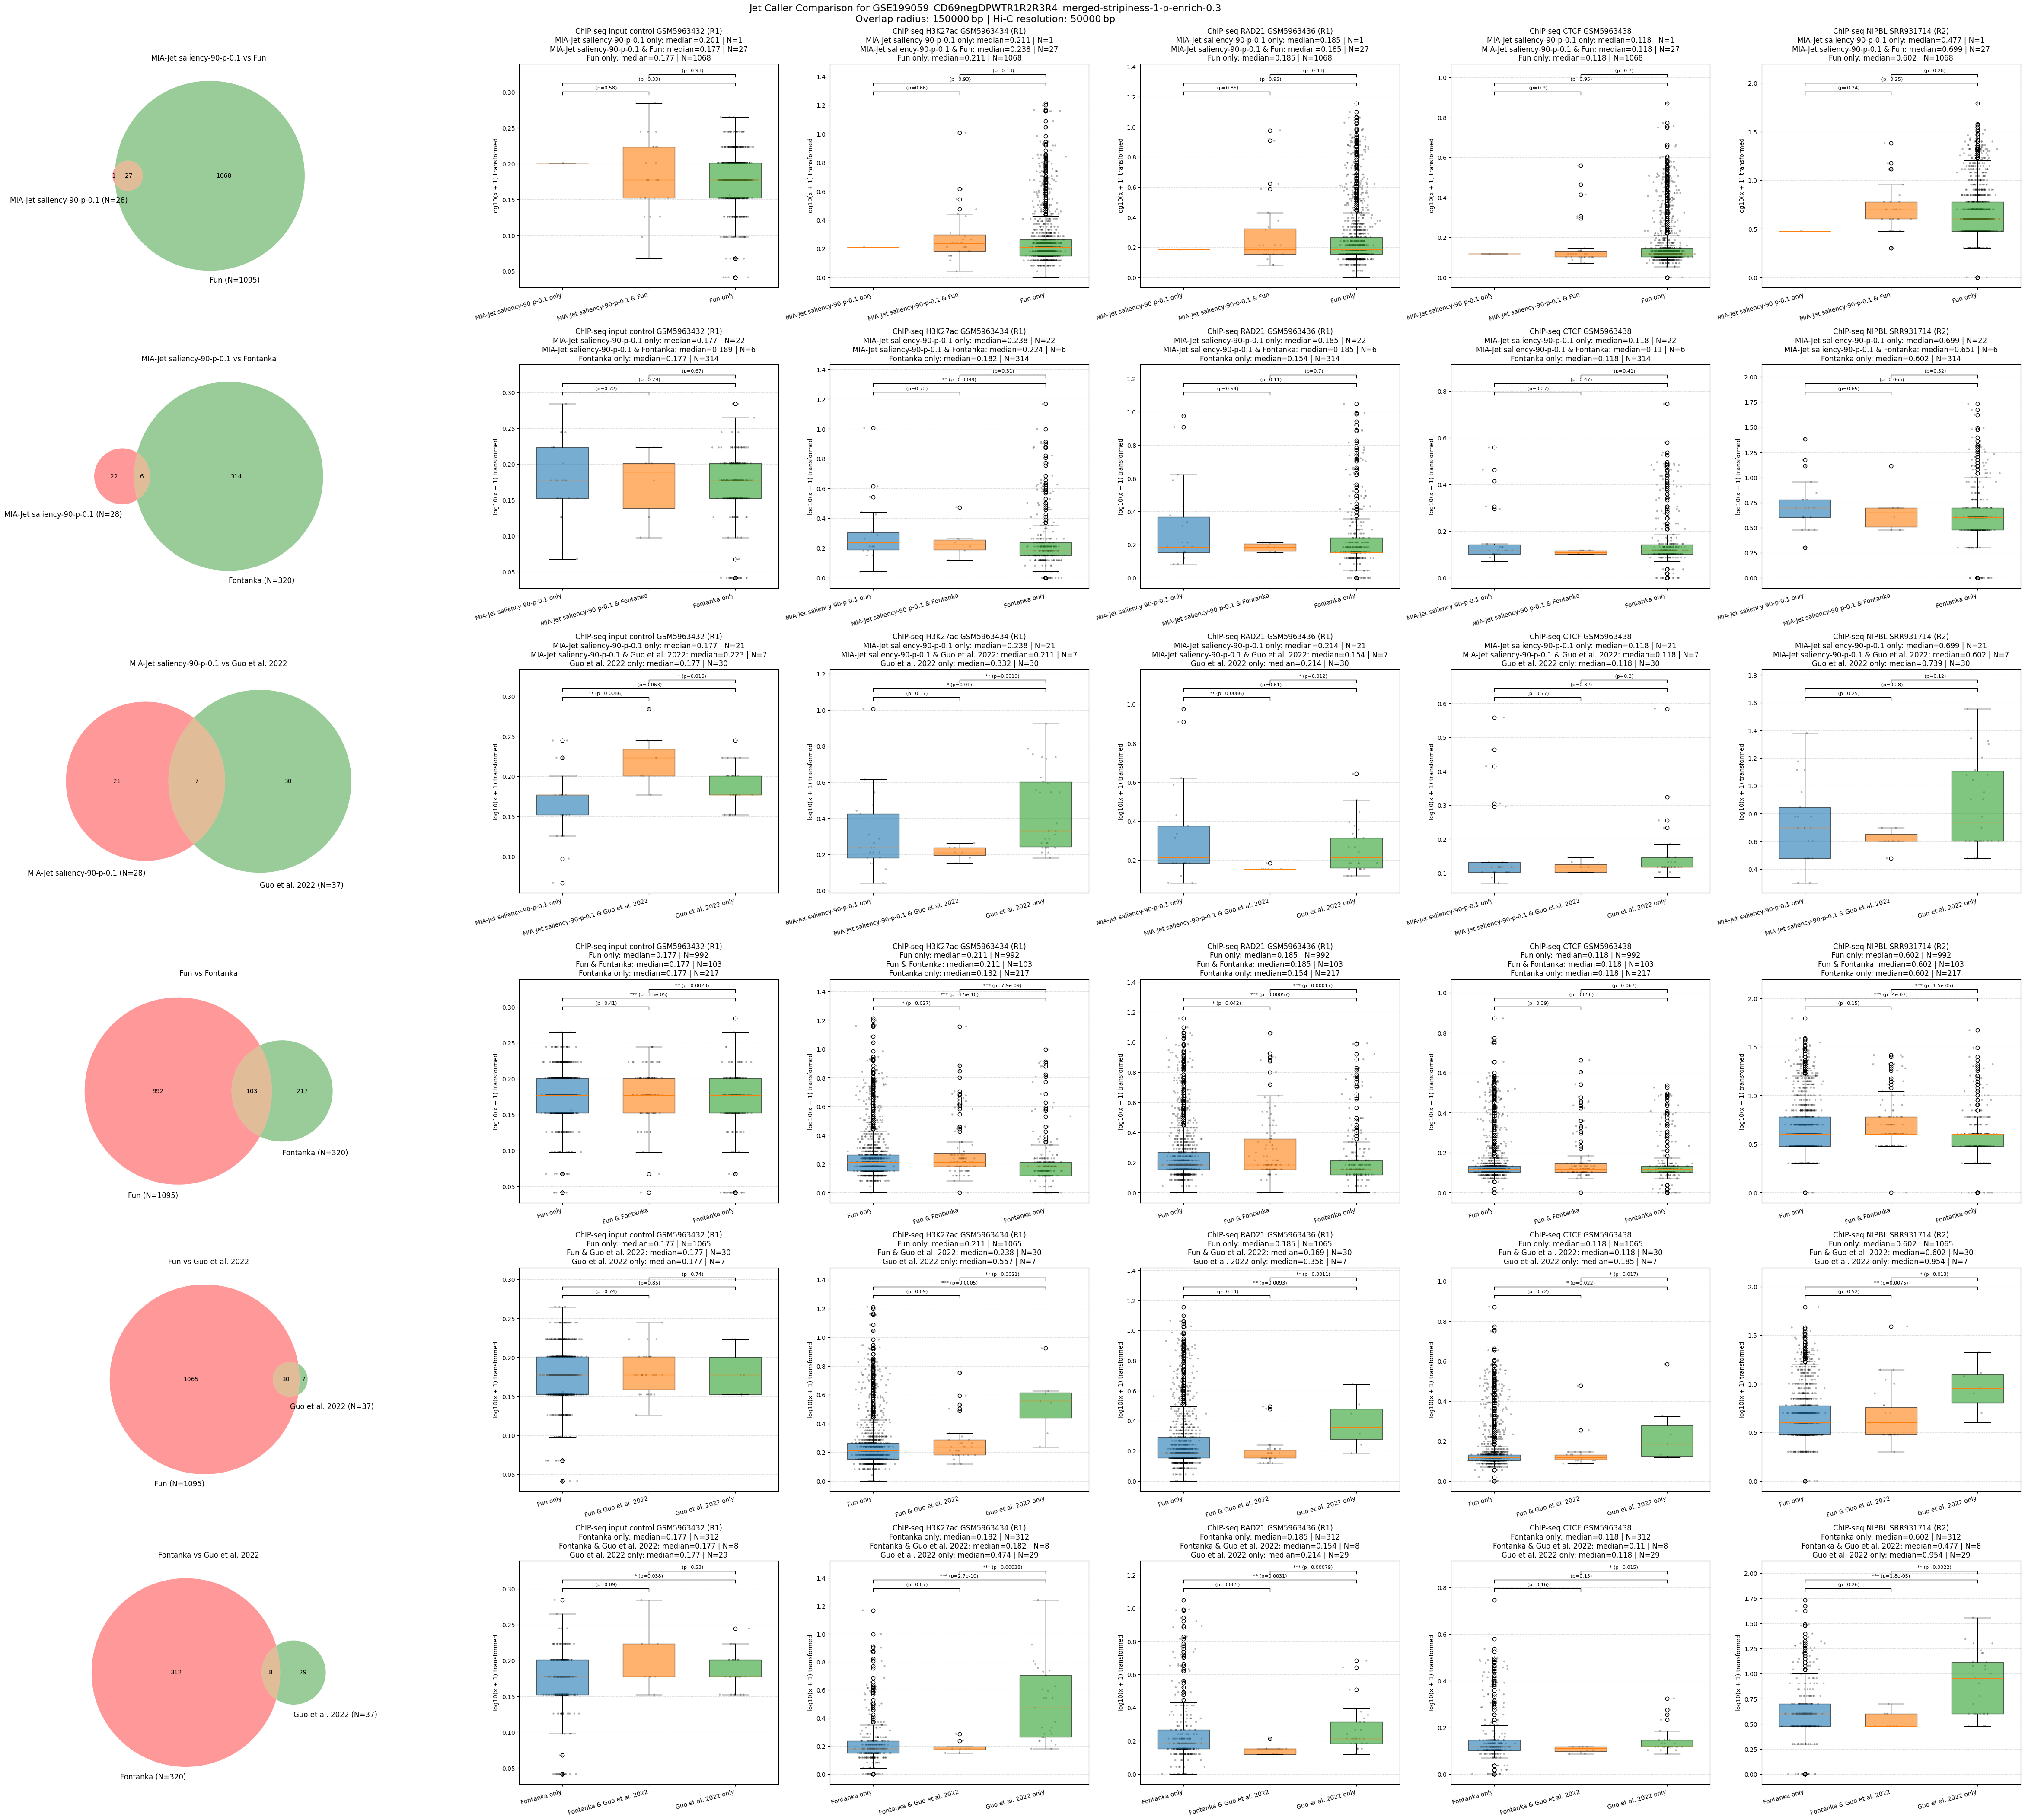

In [58]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pairs = list(itertools.combinations(names, 2))
num_pairs = len(pairs)
n_exp = len(chip_files)

fig, axes = plt.subplots(num_pairs, n_exp + 1, figsize=(8 * (n_exp + 1), 7 * num_pairs), layout='constrained', width_ratios=[2] + [1] * n_exp)

for row, (A, B) in enumerate(pairs):
    # 1) Venn diagram in col 0
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter   = results.loc[A, B]
    only_A  = total_A - inter
    only_B  = total_B - inter

    titles = [f"{A} only", f"{A} & {B}", f"{B} only"]

    ax = axes[row, 0]
    venn2((int(only_A), int(only_B), int(inter)), set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"), ax=ax)
    ax.set_title(f"{A} vs {B}")

    row_boxes = boxplot_pairs[row]     

    # counts per category (for the titles below)
    counts = [int(only_A), int(inter), int(only_B)]

    # 2) one box‐axis per experiment
    for exp_idx in range(n_exp):
        ax = axes[row, exp_idx+1]

        # gather the 3 arrays (one per category) for this experiment
        data = [row_boxes[cat][exp_idx] for cat in range(3)]
        # drop NaNs
        clean = [np.array(d)[~np.isnan(d)] for d in data]
        clean = [np.clip(vals, 0, None) for vals in clean]  # clip negative values to zero
        clean = [np.log10(vals + 1) for vals in clean]  # log transform

        positions = np.arange(1, 4) # A, A&B, B 
        bp = ax.boxplot(clean, patch_artist=True,
                        positions=positions, widths=0.6)
        
        add_pairwise_sig(ax, positions, clean)

        # color by category
        for patch, col in zip(bp['boxes'], colors[:3]):
            patch.set_facecolor(col)
            patch.set_alpha(0.6)

        # overplot jittered points
        for i, vals in enumerate(clean):
            x = np.full_like(vals, positions[i], dtype=float)
            x += np.random.normal(0, 0.08, size=len(vals))
            ax.scatter(x, vals, alpha=0.3, s=10, color='k', edgecolor='none')

        ax.set_xticks(positions)
        ax.set_xticklabels(titles, rotation=15, ha='right')

        title_boxstat = title_boxplot(chip_names[exp_idx], titles, clean)
        ax.set_title(title_boxstat)

        ax.set_ylabel("log10(x + 1) transformed")
        ax.grid(axis='y', linestyle='--', alpha=0.4)

# overall title
fig.suptitle(
    f"Jet Caller Comparison for {data_name}\n"
    f"Overlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution} bp",
    fontsize=16
)

plt.savefig(f"{save_path}/{data_name}_{result_type}_venn_diagram-box.png", dpi=400)

plt.show()
